# 1. Environment Setup and Data Import

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set font
plt.rcParams['font.sans-serif'] = ['Arial']  # Font for labels
plt.rcParams['axes.unicode_minus'] = False   # Correct dispay of negative signs

# Set visualization style
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

# Data processing libraries
from datetime import datetime, timedelta
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

print("Environment setup completed!")

Environment setup completed!


In [2]:
df = pd.read_csv("ecommerce_ad_performance.csv")
print(df.head())
print(df.info)
print(df.dtypes)

        campaign_id        date platform     ad_type target_audience  \
0  CMP_20240101_001  2024-01-01   Douyin    Brand Ad        55+ User   
1  CMP_20240101_002  2024-01-01    Xigua   Search Ad    18-25 Female   
2  CMP_20240101_003  2024-01-01   Douyin  In-feed Ad      26-35 Male   
3  CMP_20240101_004  2024-01-01    Xigua    Video Ad        55+ User   
4  CMP_20240101_005  2024-01-01  Toutiao   Splash Ad      18-25 Male   

   ad_spend  impressions  clicks  conversions     revenue    cpm     ctr  \
0  31939.63      1762636   26601         1563   701393.11  18.12  0.0151   
1  26381.96       976500   21663         2045   579900.62  27.02  0.0222   
2  32533.38      1828757   46109         5852  1796466.64  17.79  0.0252   
3  18469.65       717016   17219         1837   440477.82  25.76  0.0240   
4   3590.75       228793    4922          319   104254.73  15.69  0.0215   

      cvr   cpc    cpa   roas  hour time_period  
0  0.0588  1.20  20.43  21.96    23     evening  
1  0.0944 

In [3]:
print(df.dtypes)

campaign_id         object
date                object
platform            object
ad_type             object
target_audience     object
ad_spend           float64
impressions          int64
clicks               int64
conversions          int64
revenue            float64
cpm                float64
ctr                float64
cvr                float64
cpc                float64
cpa                float64
roas               float64
hour                 int64
time_period         object
dtype: object


# 2. Data Cleaning and Preprocessing

## 2.1. Data Type Optimization and Format Standardization

In [4]:
# Data Type Optimization
def optimize_data_types(df):
    """
    Optimize data types to save memory and improve computational efficiency
    """
    before_mem = df.memory_usage(deep=True).sum()
    print("=== Before Data Type Optimization ===")
    print(f"Memory usage: {before_mem / 1024**2:.2f} MB")
    
    # Convert to datetime
    df['date'] = pd.to_datetime(df['date'])
    
    # Optimize integer columns
    integer_columns = ['impressions', 'clicks', 'conversions','hour']
    for col in integer_columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    
    # Optimize float columns
    float_columns = ['ad_spend', 'revenue', 'cpm', 'ctr', 'cvr', 'cpc', 'cpa', 'roas']
    for col in float_columns:
        df[col] = pd.to_numeric(df[col], downcast='float')
    
    # Convert categorical variables to category type
    categorical_columns = ['platform', 'ad_type', 'target_audience','time_period']
    for col in categorical_columns:
        df[col] = df[col].astype('category')
    
    after_mem = df.memory_usage(deep=True).sum()
    print("=== After Data Type Optimization ===")
    print(f"Memory usage: {after_mem / 1024**2:.2f} MB")
    print(f"Memory reduction: {(1 - after_mem / before_mem) * 100:.1f}%")
    
    return df

# Execute data type optimization
df = optimize_data_types(df.copy())

# Add time-based features
def add_time_features(df):
    """
    Add derived features based on the time dimension
    """
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['weekday'] = df['date'].dt.weekday  # 0=Monday
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
    df['week_of_year'] = df['date'].dt.isocalendar().week
    
    # Month names
    month_names = {
        1: 'January', 2: 'February', 3: 'March', 4: 'April', 
        5: 'May', 6: 'June', 7: 'July', 8: 'August', 
        9: 'September', 10: 'October', 11: 'November', 12: 'December'
    }
    df['month_name'] = df['month'].map(month_names).astype('category')
    
    # Weekday names
    weekday_names = {
        0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
        4: 'Friday', 5: 'Saturday', 6: 'Sunday'
    }
    df['weekday_name'] = df['weekday'].map(weekday_names).astype('category')
    
    return df

df = add_time_features(df)


=== Before Data Type Optimization ===
Memory usage: 0.77 MB
=== After Data Type Optimization ===
Memory usage: 0.22 MB
Memory reduction: 71.3%


## 2.2. Outlier Detection and Handling

In [5]:
# Outlier detection functions
def detect_outliers_iqr(df, column, factor=1.5):
    """
    Detect outliers using the IQR method
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    outliers = (df[column] < lower_bound) | (df[column] > upper_bound)
    return outliers, lower_bound, upper_bound

def detect_outliers_zscore(df, column, threshold=3):
    """
    Detect outliers using the Z-score method
    """
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    outliers = z_scores > threshold
    return outliers

# Outlier detection for key metrics
metrics_to_check = ['ctr', 'cvr', 'roas', 'cpa']
outlier_summary = {}

print("=== Outlier Detection Results ===")
for metric in metrics_to_check:
    if metric in df.columns:
        # IQR method
        iqr_outliers, lower, upper = detect_outliers_iqr(df, metric)
        # Z-score method
        zscore_outliers = detect_outliers_zscore(df, metric)
        
        iqr_count = iqr_outliers.sum()
        zscore_count = zscore_outliers.sum()
        
        outlier_summary[metric] = {
            'iqr_outliers': iqr_count,
            'zscore_outliers': zscore_count,
            'lower_bound': lower,
            'upper_bound': upper
        }
        
        print(f"\n{metric}:")
        print(f"  IQR outliers: {iqr_count} ({iqr_count/len(df)*100:.1f}%)")
        print(f"  Z-score outliers: {zscore_count} ({zscore_count/len(df)*100:.1f}%)")
        print(f"  Normal range: [{lower:.4f}, {upper:.4f}]")

# Outlier handling
def handle_outliers(df):
    """
    Handle outliers using the capping method
    """
    df_processed = df.copy()
    
    # Apply capping for key metrics
    for metric in ['ctr', 'cvr', 'roas']:
        if metric in df_processed.columns:
            outliers, lower, upper = detect_outliers_iqr(df_processed, metric)
            df_processed.loc[df_processed[metric] < lower, metric] = lower
            df_processed.loc[df_processed[metric] > upper, metric] = upper
    
    return df_processed

# Apply outlier handling (cap method)
df_clean = handle_outliers(df)
print(f"\nDataset size after handling: {df_clean.shape}")
print(f"Original dataset size: {df.shape}")


=== Outlier Detection Results ===

ctr:
  IQR outliers: 24 (1.3%)
  Z-score outliers: 15 (0.8%)
  Normal range: [0.0034, 0.0461]

cvr:
  IQR outliers: 46 (2.5%)
  Z-score outliers: 26 (1.4%)
  Normal range: [0.0182, 0.1608]

roas:
  IQR outliers: 103 (5.7%)
  Z-score outliers: 42 (2.3%)
  Normal range: [-16.7200, 85.2000]

cpa:
  IQR outliers: 70 (3.9%)
  Z-score outliers: 25 (1.4%)
  Normal range: [-3.1675, 24.3725]

Dataset size after handling: (1807, 26)
Original dataset size: (1807, 26)


## 2.3. Feature Engineering and Derived Features

In [6]:
# Feature Engineering Function
def create_derived_features(df_clean):
    """
    Create derived features and business metrics
    """
    df_enhanced = df_clean.copy()
    
    # Efficiency metrics
    df_enhanced['cpm'] = df_enhanced['ad_spend'] / df_enhanced['impressions'] * 1000
    df_enhanced['effective_cpm'] = df_enhanced['ad_spend'] / df_enhanced['conversions'] * 1000
    
    # Quality levels
    df_enhanced['ctr_level'] = pd.cut(df_enhanced['ctr'], 
                                     bins=[0, 0.01, 0.02, 0.035, 1], 
                                     labels=['Low', 'Medium', 'High', 'Excellent'])
    
    df_enhanced['cvr_level'] = pd.cut(df_enhanced['cvr'], 
                                     bins=[0, 0.05, 0.1, 0.15, 1], 
                                     labels=['Low', 'Medium', 'High', 'Excellent'])
    
    df_enhanced['roas_level'] = pd.cut(df_enhanced['roas'], 
                                      bins=[0, 1, 2, 3, 100], 
                                      labels=['Loss', 'Break-even', 'Profitable', 'Highly Profitable'])
    
    # Spend scale levels
    df_enhanced['spend_level'] = pd.cut(df_enhanced['ad_spend'], 
                                       bins=[0, 5000, 15000, 30000, float('inf')], 
                                       labels=['Small', 'Medium', 'Large', 'Extra Large'])
    
    # User value metric
    df_enhanced['avg_order_value'] = df_enhanced['revenue'] / df_enhanced['conversions']
    df_enhanced['avg_order_value'] = df_enhanced['avg_order_value'].fillna(0)
    
    # Competitiveness metric
    platform_avg_cpc = df_enhanced.groupby('platform')['cpc'].mean()
    df_enhanced['cpc_vs_platform_avg'] = df_enhanced.apply(
        lambda x: x['cpc'] / platform_avg_cpc[x['platform']], axis=1)
    
    # Audience segmentation
    def categorize_audience(audience):
        if '18-25' in audience:
            return 'Gen Z'
        elif '26-35' in audience:
            return 'Millennials'
        elif '36-45' in audience:
            return 'Gen X'
        else:
            return 'Baby Boomers'
    
    df_enhanced['generation'] = df_enhanced['target_audience'].apply(categorize_audience)
    
    # Gender extraction
    df_enhanced['gender'] = df_enhanced['target_audience'].apply(
        lambda x: 'Female' if 'Female' in x else ('Male' if 'Male' in x else 'Mixed'))
    
    return df_enhanced


# Run feature engineering on df_clean
df_enhanced = create_derived_features(df_clean)

print("=== Feature Engineering Completed ===")
print(f"New features added: {len(df_enhanced.columns) - len(df_clean.columns)}")
print(f"Total number of features: {len(df_enhanced.columns)}")
print("\nNew feature list:")
new_features = set(df_enhanced.columns) - set(df_clean.columns)
for feature in sorted(new_features):
    print(f"  - {feature}")

# Check derived feature distributions
print("\n=== Core Categorical Feature Distributions ===")
categorical_features = ['ctr_level', 'cvr_level', 'roas_level', 'spend_level', 'generation']
for feature in categorical_features:
    if feature in df_enhanced.columns:
        print(f"\n{feature}:")
        print(df_enhanced[feature].value_counts())


=== Feature Engineering Completed ===
New features added: 9
Total number of features: 35

New feature list:
  - avg_order_value
  - cpc_vs_platform_avg
  - ctr_level
  - cvr_level
  - effective_cpm
  - gender
  - generation
  - roas_level
  - spend_level

=== Core Categorical Feature Distributions ===

ctr_level:
ctr_level
High         1120
Medium        494
Excellent     193
Low             0
Name: count, dtype: int64

cvr_level:
cvr_level
Medium       1186
High          511
Excellent      72
Low            38
Name: count, dtype: int64

roas_level:
roas_level
Highly Profitable    1807
Loss                    0
Break-even              0
Profitable              0
Name: count, dtype: int64

spend_level:
spend_level
Large          747
Extra Large    522
Medium         494
Small           44
Name: count, dtype: int64

generation:
generation
Gen Z           465
Baby Boomers    455
Gen X           450
Millennials     437
Name: count, dtype: int64


# 3. Basic Visualization Analysis

## 3.1. Overall Campaign Overview Visualization

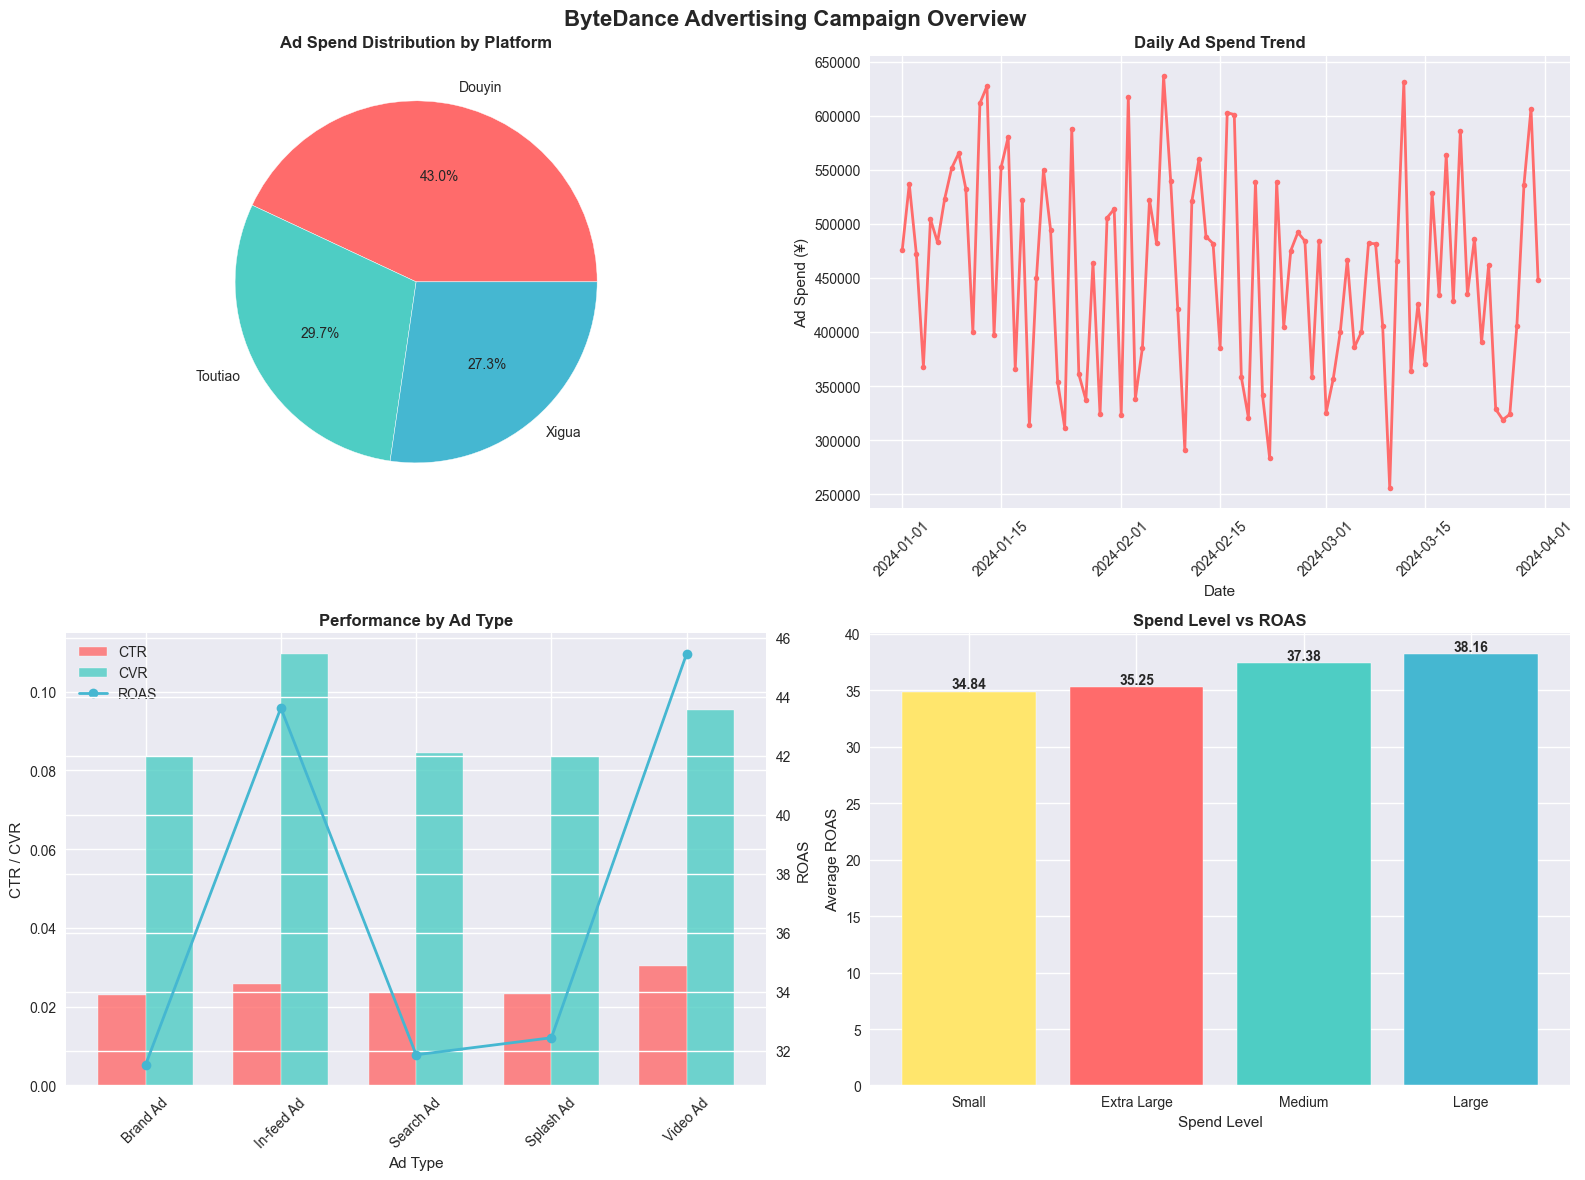

=== Key Metrics Summary ===
Total Ad Spend: 41,412,068 ¥
Total Impressions: 1,989,061,538
Total Clicks: 50,162,998
Total Conversions: 4,689,645
Total Revenue: 1,582,474,869 ¥
Average CTR: 0.025
Average CVR: 0.091
Average ROAS: 37.03
Average CPA: 11 ¥


In [7]:
# Set chart style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create overall campaign overview charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ByteDance Advertising Campaign Overview', fontsize=16, fontweight='bold')

# 1. Ad spend distribution by platform
platform_spend = df_enhanced.groupby('platform')['ad_spend'].sum().sort_values(ascending=False)
axes[0, 0].pie(platform_spend.values, labels=platform_spend.index, autopct='%1.1f%%', 
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Ad Spend Distribution by Platform', fontsize=12, fontweight='bold')

# 2. Daily spend trend
daily_metrics = df_enhanced.groupby('date').agg({
    'ad_spend': 'sum',
    'impressions': 'sum',
    'clicks': 'sum',
    'conversions': 'sum'
}).reset_index()

axes[0, 1].plot(daily_metrics['date'], daily_metrics['ad_spend'], 
                color='#FF6B6B', linewidth=2, marker='o', markersize=4)
axes[0, 1].set_title('Daily Ad Spend Trend', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Ad Spend (¥)')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Performance comparison by ad type (Dual Y-Axis)
ad_type_performance = df_enhanced.groupby('ad_type').agg({
    'ctr': 'mean',
    'cvr': 'mean',
    'roas': 'mean'
}).reset_index()

x = range(len(ad_type_performance))
width = 0.35

# Left y-axis: CTR & CVR
axes[1, 0].bar([i - width/2 for i in x], ad_type_performance['ctr'], 
               width, label='CTR', color='#FF6B6B', alpha=0.8)
axes[1, 0].bar([i + width/2 for i in x], ad_type_performance['cvr'], 
               width, label='CVR', color='#4ECDC4', alpha=0.8)

axes[1, 0].set_title('Performance by Ad Type', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Ad Type')
axes[1, 0].set_ylabel('CTR / CVR')
axes[1, 0].set_xticks(list(x))
axes[1, 0].set_xticklabels(ad_type_performance['ad_type'], rotation=45)

# Right y-axis: ROAS
ax2 = axes[1, 0].twinx()
ax2.plot(x, ad_type_performance['roas'], color='#45B7D1', 
         marker='o', linewidth=2, label='ROAS')
ax2.set_ylabel('ROAS')

# Merge legends
lines, labels = axes[1, 0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
axes[1, 0].legend(lines + lines2, labels + labels2, loc='upper left')

# 4. Relationship between spend level and ROAS
spend_roas = df_enhanced.groupby('spend_level')['roas'].mean().sort_values()
colors = ['#FFE66D', '#FF6B6B', '#4ECDC4', '#45B7D1']
bars = axes[1, 1].bar(range(len(spend_roas)), spend_roas.values, 
               color=colors[:len(spend_roas)])
axes[1, 1].set_title('Spend Level vs ROAS', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Spend Level')
axes[1, 1].set_ylabel('Average ROAS')
axes[1, 1].set_xticks(range(len(spend_roas)))
axes[1, 1].set_xticklabels(spend_roas.index)

# Add value labels
for i, v in enumerate(spend_roas.values):
    axes[1, 1].text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Generate summary stats
print("=== Key Metrics Summary ===")
summary_stats = {
    'Total Ad Spend': f"{df_enhanced['ad_spend'].sum():,.0f} ¥",
    'Total Impressions': f"{df_enhanced['impressions'].sum():,}",
    'Total Clicks': f"{df_enhanced['clicks'].sum():,}", 
    'Total Conversions': f"{df_enhanced['conversions'].sum():,}",
    'Total Revenue': f"{df_enhanced['revenue'].sum():,.0f} ¥",
    'Average CTR': f"{df_enhanced['ctr'].mean():.3f}",
    'Average CVR': f"{df_enhanced['cvr'].mean():.3f}",
    'Average ROAS': f"{df_enhanced['roas'].mean():.2f}",
    'Average CPA': f"{df_enhanced['cpa'].mean():.0f} ¥"
}

for metric, value in summary_stats.items():
    print(f"{metric}: {value}")


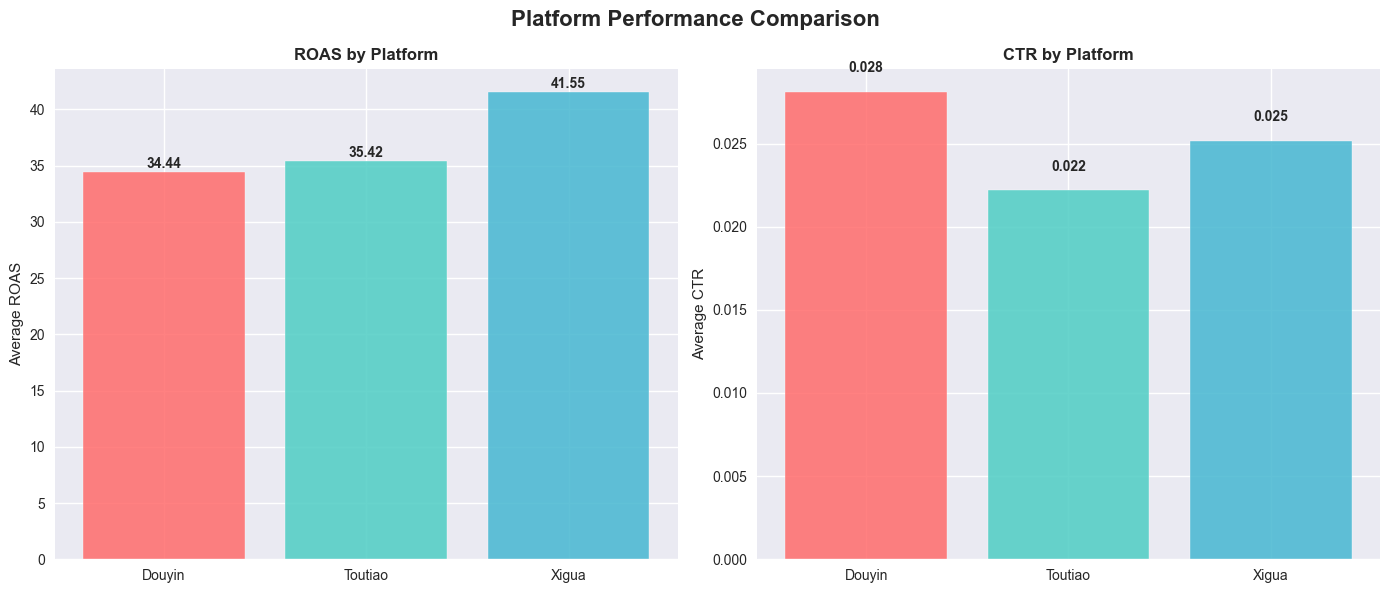

In [8]:
# Create platform performance comparison charts
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Platform Performance Comparison', fontsize=16, fontweight='bold')

# Calculate platform metrics
platform_metrics = df_enhanced.groupby('platform').agg({
    'roas': 'mean',
    'ctr': 'mean'
}).reset_index()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. ROAS by Platform
bars1 = axes[0].bar(platform_metrics['platform'], platform_metrics['roas'], 
                    color=colors, alpha=0.85)
axes[0].set_title('ROAS by Platform', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average ROAS')

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, height + 0.05, 
                 f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# 2. CTR by Platform
bars2 = axes[1].bar(platform_metrics['platform'], platform_metrics['ctr'], 
                    color=colors, alpha=0.85)
axes[1].set_title('CTR by Platform', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average CTR')

# Add value labels on top of bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, height + 0.001, 
                 f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


## 3.2. Advanced Visualization Analysis

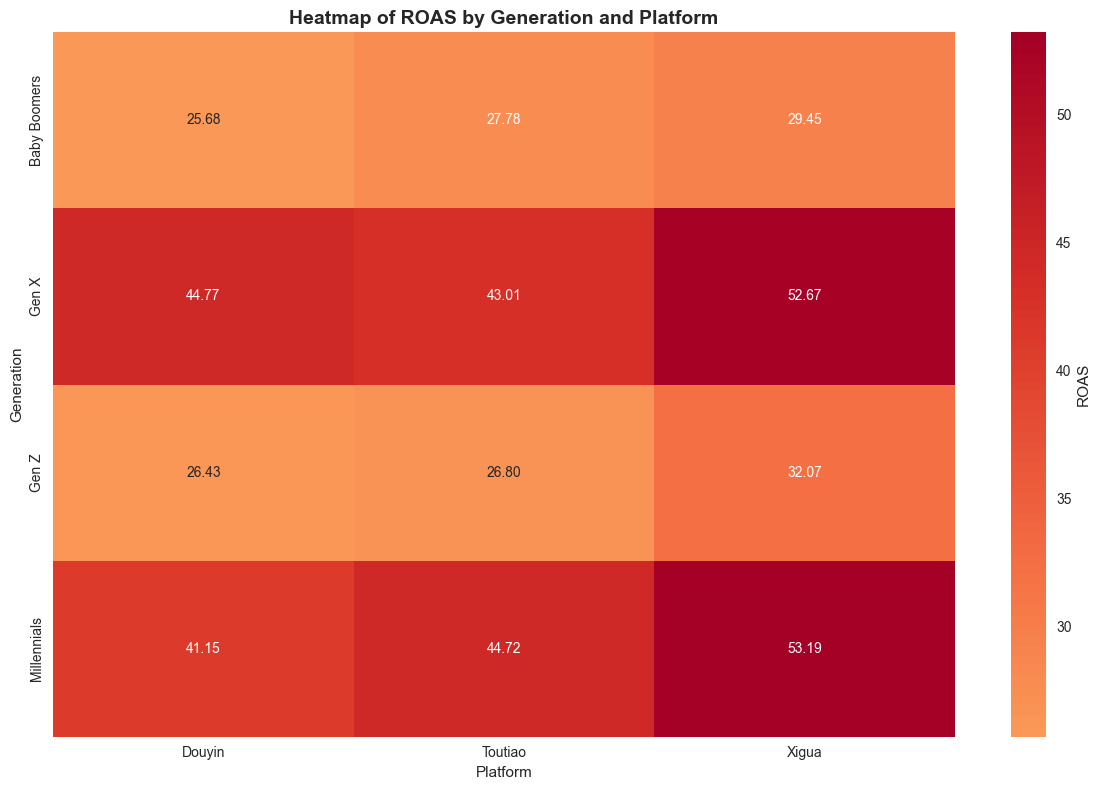

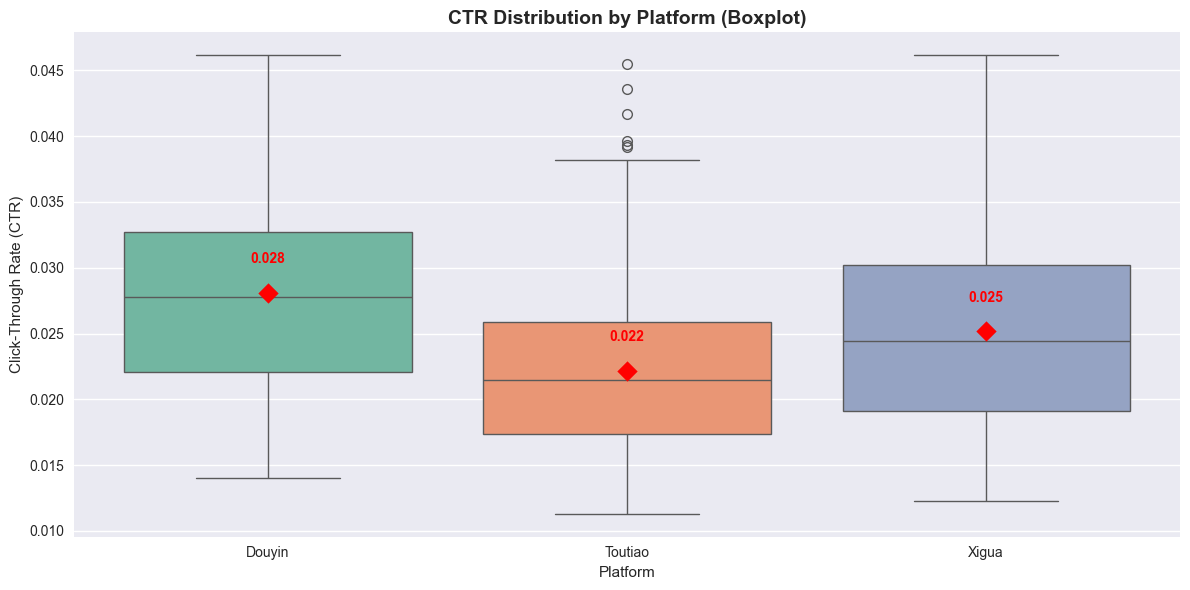

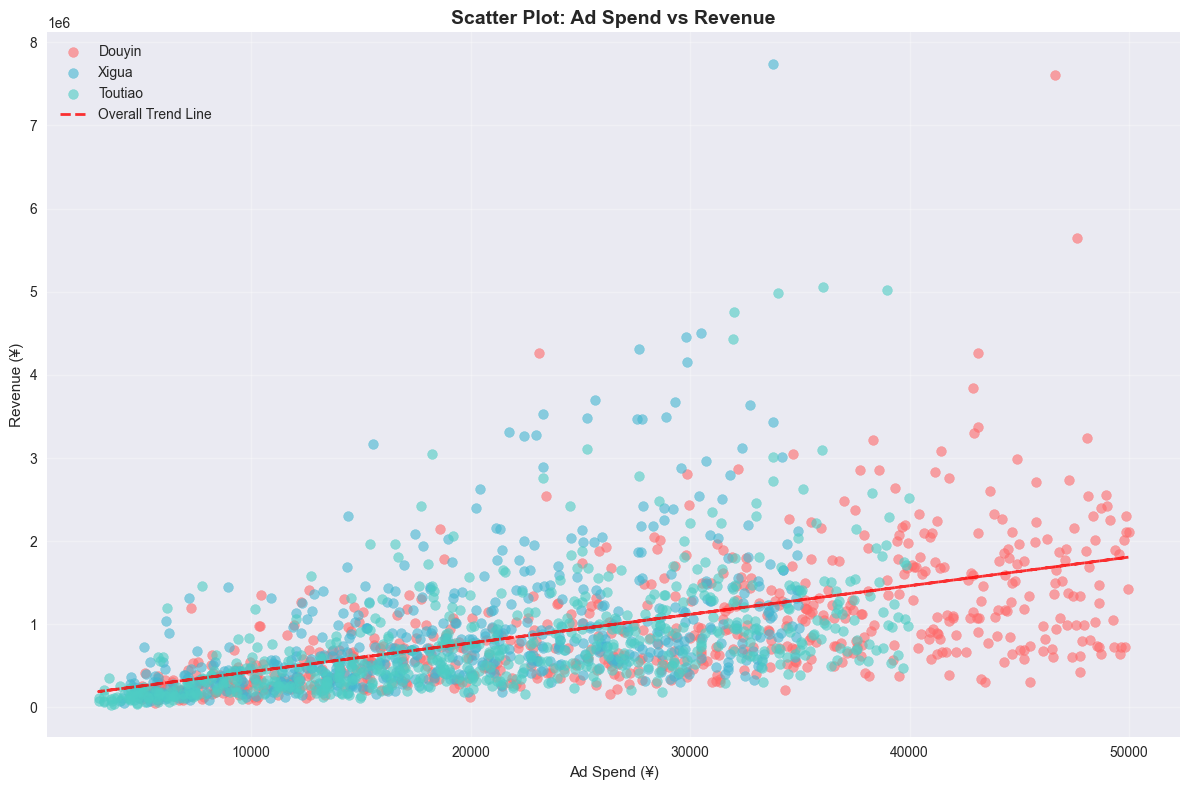

Correlation between Ad Spend and Revenue: 0.525


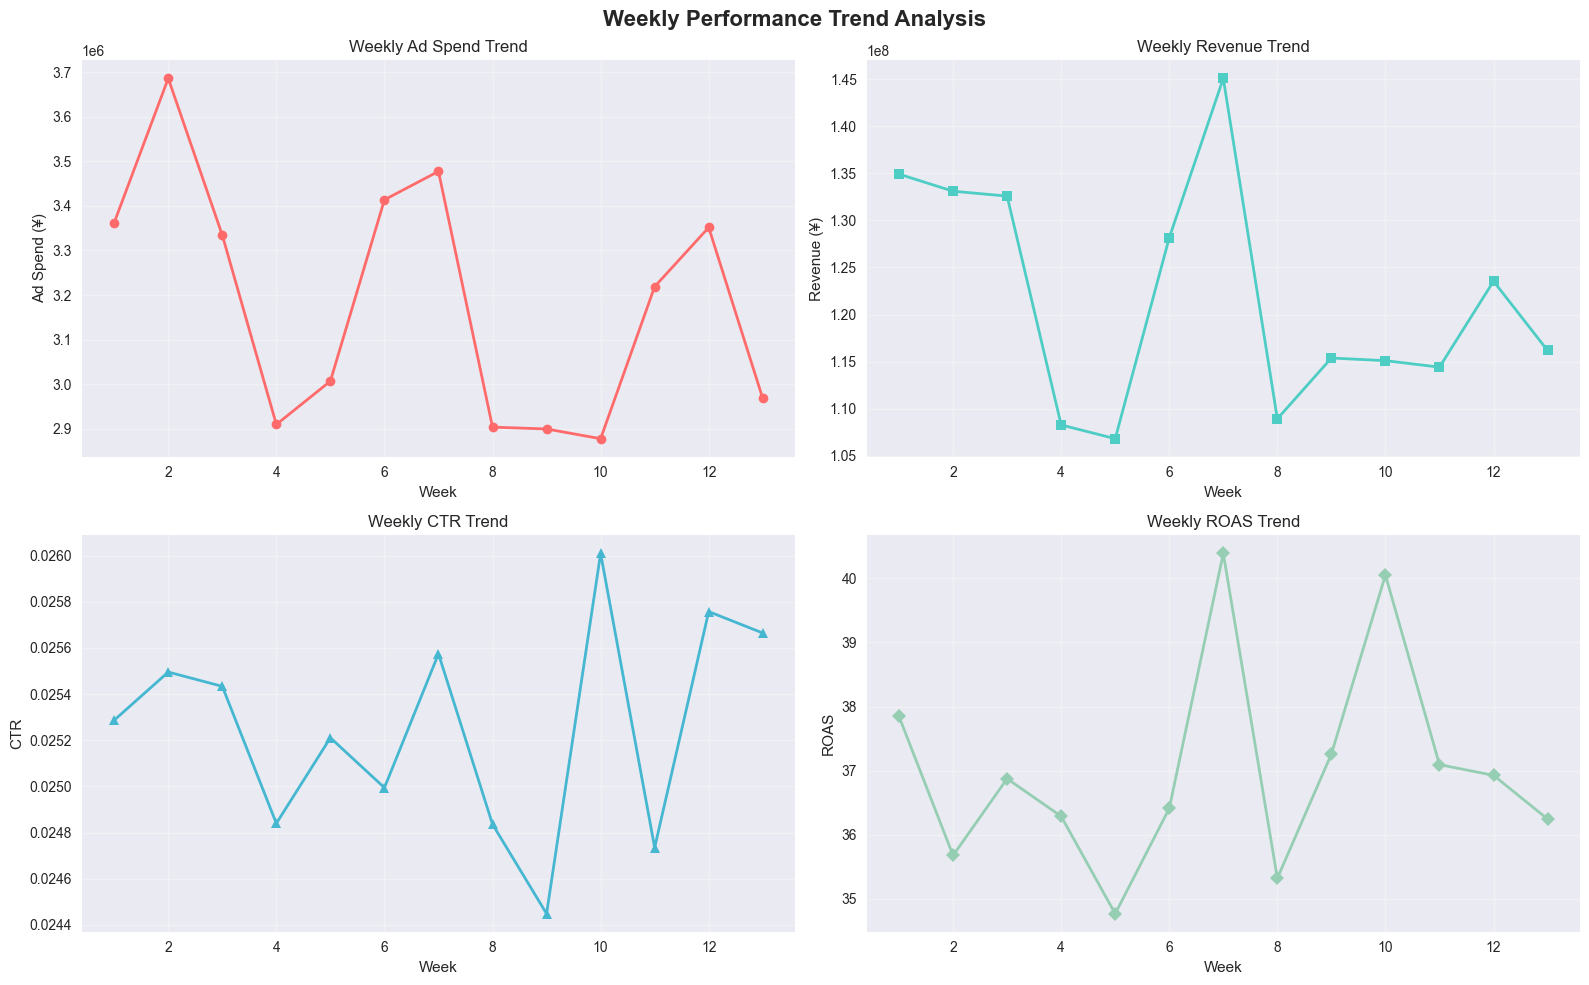

In [9]:
# 1. Heatmap: Performance of different generations across platforms
pivot_data = df_enhanced.pivot_table(
    values='roas', 
    index='generation', 
    columns='platform', 
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, cmap='RdYlBu_r', center=2, 
            fmt='.2f', cbar_kws={'label': 'ROAS'})
plt.title('Heatmap of ROAS by Generation and Platform', fontsize=14, fontweight='bold')
plt.xlabel('Platform')
plt.ylabel('Generation')
plt.tight_layout()
plt.show()

# 2. Boxplot: CTR distribution comparison by platform
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_enhanced, x='platform', y='ctr', palette='Set2')
plt.title('CTR Distribution by Platform (Boxplot)', fontsize=14, fontweight='bold')
plt.xlabel('Platform')
plt.ylabel('Click-Through Rate (CTR)')

# Add mean markers
platform_means = df_enhanced.groupby('platform')['ctr'].mean()
for i, platform in enumerate(platform_means.index):
    plt.scatter(i, platform_means[platform], color='red', s=100, zorder=5, marker='D')
    plt.text(i, platform_means[platform] + 0.002, f'{platform_means[platform]:.3f}', 
             ha='center', va='bottom', fontweight='bold', color='red')

plt.tight_layout()
plt.show()

# 3. Scatter plot: Relationship between Ad Spend and Revenue
plt.figure(figsize=(12, 8))
colors = {'Douyin': '#FF6B6B', 'Toutiao': '#4ECDC4', 'Xigua': '#45B7D1'}

for platform in df_enhanced['platform'].unique():
    platform_data = df_enhanced[df_enhanced['platform'] == platform]
    plt.scatter(platform_data['ad_spend'], platform_data['revenue'], 
                alpha=0.6, c=colors[platform], label=platform, s=50)

# Add overall trend line
z = np.polyfit(df_enhanced['ad_spend'], df_enhanced['revenue'], 1)
p = np.poly1d(z)
plt.plot(df_enhanced['ad_spend'], p(df_enhanced['ad_spend']), 
         "r--", alpha=0.8, linewidth=2, label='Overall Trend Line')

plt.xlabel('Ad Spend (¥)')
plt.ylabel('Revenue (¥)')
plt.title('Scatter Plot: Ad Spend vs Revenue', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation
correlation = df_enhanced['ad_spend'].corr(df_enhanced['revenue'])
print(f"Correlation between Ad Spend and Revenue: {correlation:.3f}")

# 4. Time Series Analysis: Weekly Performance Trends
weekly_performance = df_enhanced.groupby('week_of_year').agg({
    'ad_spend': 'sum',
    'revenue': 'sum',
    'ctr': 'mean',
    'cvr': 'mean',
    'roas': 'mean'
}).reset_index()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Weekly Performance Trend Analysis', fontsize=16, fontweight='bold')

# Weekly ad spend trend
axes[0, 0].plot(weekly_performance['week_of_year'], weekly_performance['ad_spend'], 
                marker='o', linewidth=2, color='#FF6B6B')
axes[0, 0].set_title('Weekly Ad Spend Trend')
axes[0, 0].set_xlabel('Week')
axes[0, 0].set_ylabel('Ad Spend (¥)')
axes[0, 0].grid(True, alpha=0.3)

# Weekly revenue trend
axes[0, 1].plot(weekly_performance['week_of_year'], weekly_performance['revenue'], 
                marker='s', linewidth=2, color='#4ECDC4')
axes[0, 1].set_title('Weekly Revenue Trend')
axes[0, 1].set_xlabel('Week')
axes[0, 1].set_ylabel('Revenue (¥)')
axes[0, 1].grid(True, alpha=0.3)

# Weekly CTR trend
axes[1, 0].plot(weekly_performance['week_of_year'], weekly_performance['ctr'], 
                marker='^', linewidth=2, color='#45B7D1')
axes[1, 0].set_title('Weekly CTR Trend')
axes[1, 0].set_xlabel('Week')
axes[1, 0].set_ylabel('CTR')
axes[1, 0].grid(True, alpha=0.3)

# Weekly ROAS trend
axes[1, 1].plot(weekly_performance['week_of_year'], weekly_performance['roas'], 
                marker='D', linewidth=2, color='#96CEB4')
axes[1, 1].set_title('Weekly ROAS Trend')
axes[1, 1].set_xlabel('Week')
axes[1, 1].set_ylabel('ROAS')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3.3. Interactive Visualizations

In [10]:
# Interactive Visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 1. Interactive Bubble Chart: Campaign Performance Overview
fig = px.scatter(df_enhanced, 
                 x='ctr', y='cvr', size='ad_spend', color='platform',
                 hover_data=['roas', 'conversions', 'revenue'],
                 title='Campaign Performance Overview (Bubble Size = Ad Spend)',
                 labels={'ctr': 'CTR', 'cvr': 'CVR'},
                 color_discrete_map={'Douyin': '#FF6B6B', 'Toutiao': '#4ECDC4', 'Xigua': '#45B7D1'})

fig.update_layout(
    width=800, height=600,
    showlegend=True,
    font=dict(size=12)
)
fig.show()

# 2. Interactive Time Series: Multi-Metric Comparison
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Daily Ad Spend', 'Daily Revenue', 'Daily CTR', 'Daily ROAS'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Add daily data
daily_data = df_enhanced.groupby('date').agg({
    'ad_spend': 'sum',
    'revenue': 'sum', 
    'ctr': 'mean',
    'roas': 'mean'
}).reset_index()

fig.add_trace(
    go.Scatter(x=daily_data['date'], y=daily_data['ad_spend'], 
               mode='lines+markers', name='Ad Spend', line=dict(color='#FF6B6B')),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=daily_data['date'], y=daily_data['revenue'],
               mode='lines+markers', name='Revenue', line=dict(color='#4ECDC4')),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=daily_data['date'], y=daily_data['ctr'],
               mode='lines+markers', name='CTR', line=dict(color='#45B7D1')),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=daily_data['date'], y=daily_data['roas'],
               mode='lines+markers', name='ROAS', line=dict(color='#96CEB4')),
    row=2, col=2
)

fig.update_layout(height=800, showlegend=False, title_text="Interactive Multi-Metric Time Trend Analysis")
fig.show()

# 3. Interactive Funnel Chart: Conversion Path Analysis
funnel_data = {
    'Impressions': df_enhanced['impressions'].sum(),
    'Clicks': df_enhanced['clicks'].sum(), 
    'Conversions': df_enhanced['conversions'].sum()
}

fig = go.Figure(go.Funnel(
    y = list(funnel_data.keys()),
    x = list(funnel_data.values()),
    textinfo = "value+percent initial",
    marker = {"color": ["#FF6B6B", "#4ECDC4", "#45B7D1"],
              "line": {"width": [2, 2, 2], "color": ["white", "white", "white"]}},
    connector = {"line": {"color": "royalblue", "dash": "dot", "width": 3}}
))

fig.update_layout(
    title="Advertising Conversion Funnel Analysis",
    font_size=13,
    width=600, height=500
)
fig.show()

print("=== Conversion Funnel Key Metrics ===")
print(f"Impressions to Clicks Conversion Rate: {(funnel_data['Clicks']/funnel_data['Impressions']*100):.2f}%")
print(f"Clicks to Conversions Conversion Rate: {(funnel_data['Conversions']/funnel_data['Clicks']*100):.2f}%")
print(f"Overall Conversion Rate: {(funnel_data['Conversions']/funnel_data['Impressions']*100):.4f}%")


=== Conversion Funnel Key Metrics ===
Impressions to Clicks Conversion Rate: 2.52%
Clicks to Conversions Conversion Rate: 9.35%
Overall Conversion Rate: 0.2358%


# 4. In-Depth Analysis: User Segments and Platform Performance

## 4.1. User Segment Analysis

=== Generation Analysis Results ===
              Total Spend  Average Spend  Total Revenue  Average Revenue  \
generation                                                                 
Baby Boomers  10480356.92      23033.751   2.878375e+08       632609.795   
Gen X         10175638.26      22612.529   4.958453e+08      1101878.404   
Gen Z         10486297.29      22551.177   2.951762e+08       634787.627   
Millennials   10269775.20      23500.630   5.036159e+08      1152439.095   

              Avg CTR  Avg CVR  Avg ROAS    Avg CPA  Avg Order Value  
generation                                                            
Baby Boomers    0.018    0.083    27.565  16.419001          382.715  
Gen X           0.024    0.106    46.734   9.843000          407.756  
Gen Z           0.031    0.077    28.399  10.393000          247.593  
Millennials     0.029    0.100    46.058   8.477000          342.372  

=== Gender Analysis Results ===
        Total Spend  Number of Campaigns  Total 

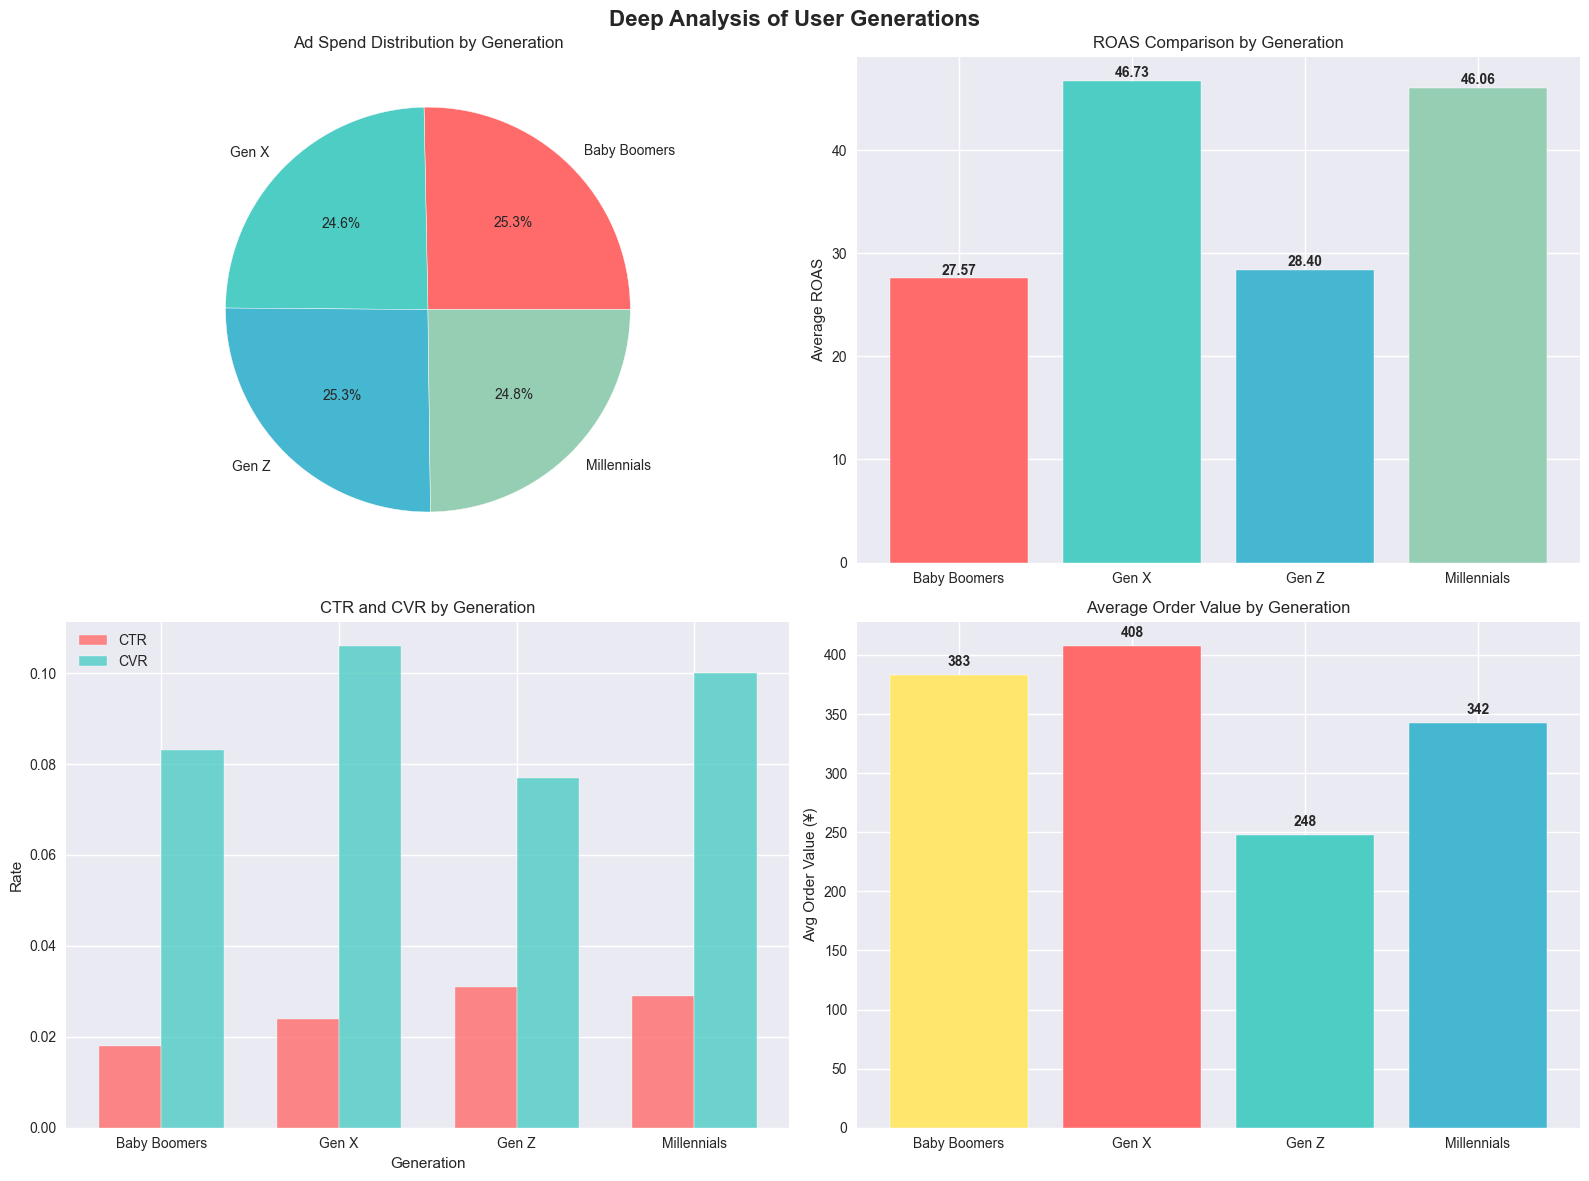

In [11]:
# User Segment Deep Analysis
def analyze_user_segments(df):
    """
    Comprehensive user segment analysis function
    """
    # 1. Generation Analysis
    generation_analysis = df.groupby('generation').agg({
        'ad_spend': ['sum', 'mean'],
        'revenue': ['sum', 'mean'],
        'ctr': 'mean',
        'cvr': 'mean', 
        'roas': 'mean',
        'cpa': 'mean',
        'avg_order_value': 'mean'
    }).round(3)
    
    generation_analysis.columns = [
        'Total Spend', 'Average Spend', 'Total Revenue', 'Average Revenue', 
        'Avg CTR', 'Avg CVR', 'Avg ROAS', 'Avg CPA', 'Avg Order Value'
    ]
    
    # 2. Gender Analysis
    gender_analysis = df.groupby('gender').agg({
        'ad_spend': ['sum', 'count'],
        'revenue': 'sum',
        'ctr': 'mean',
        'cvr': 'mean',
        'roas': 'mean'
    }).round(3)
    
    gender_analysis.columns = [
        'Total Spend', 'Number of Campaigns', 'Total Revenue', 
        'Avg CTR', 'Avg CVR', 'Avg ROAS'
    ]
    
    # 3. Cross Analysis: Platform × Generation
    cross_analysis = df.pivot_table(
        values=['ctr', 'cvr', 'roas'],
        index='generation',
        columns='platform',
        aggfunc='mean'
    ).round(3)
    
    return generation_analysis, gender_analysis, cross_analysis

# Run analysis
gen_analysis, gender_analysis, cross_analysis = analyze_user_segments(df_enhanced)

print("=== Generation Analysis Results ===")
print(gen_analysis)

print("\n=== Gender Analysis Results ===") 
print(gender_analysis)

print("\n=== Cross Analysis (CTR) by Generation × Platform ===")
print(cross_analysis['ctr'])

# Visualization of generation analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Deep Analysis of User Generations', fontsize=16, fontweight='bold')

# 1. Spend distribution by generation
axes[0, 0].pie(gen_analysis['Total Spend'], labels=gen_analysis.index, autopct='%1.1f%%',
               colors=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 0].set_title('Ad Spend Distribution by Generation')

# 2. ROAS comparison by generation
bars = axes[0, 1].bar(gen_analysis.index, gen_analysis['Avg ROAS'], 
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
axes[0, 1].set_title('ROAS Comparison by Generation')
axes[0, 1].set_ylabel('Average ROAS')
# Add value labels
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{height:.2f}', ha='center', va='bottom', fontweight='bold')

# 3. CTR vs CVR by generation
x = range(len(gen_analysis))
width = 0.35
axes[1, 0].bar([i - width/2 for i in x], gen_analysis['Avg CTR'], 
               width, label='CTR', color='#FF6B6B', alpha=0.8)
axes[1, 0].bar([i + width/2 for i in x], gen_analysis['Avg CVR'], 
               width, label='CVR', color='#4ECDC4', alpha=0.8)
axes[1, 0].set_title('CTR and CVR by Generation')
axes[1, 0].set_xlabel('Generation')
axes[1, 0].set_ylabel('Rate')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(gen_analysis.index)
axes[1, 0].legend()

# 4. Average Order Value by generation
axes[1, 1].bar(gen_analysis.index, gen_analysis['Avg Order Value'],
               color=['#FFE66D', '#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[1, 1].set_title('Average Order Value by Generation')
axes[1, 1].set_ylabel('Avg Order Value (¥)')
# Add value labels
for i, v in enumerate(gen_analysis['Avg Order Value']):
    axes[1, 1].text(i, v + 5, f'{v:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


<h2 style="text-align:center; color:white;">User Value Segmentation Analysis</h2>

<div style="display: flex; justify-content: space-between; gap: 15px;">

  <div style="background: linear-gradient(135deg, #6A5ACD, #9370DB); 
              padding: 20px; border-radius: 15px; flex: 1; color: white; text-align: center;">
    <h3>Gen Z</h3>
    <p>18–25 years old</p>
    <p><b>CTR:</b> 3.1%<br><b>ROAS:</b> 28.4<br><b>AOV:</b> ¥248</p>
    <p style="font-size:14px;">High engagement but lowest purchase size.</p>
  </div>

  <div style="background: linear-gradient(135deg, #FF69B4, #FF8C94); 
              padding: 20px; border-radius: 15px; flex: 1; color: white; text-align: center;">
    <h3>Millennials</h3>
    <p>26–35 years old</p>
    <p><b>CTR:</b> 2.9%<br><b>ROAS:</b> 46.1<br><b>AOV:</b> ¥342</p>
    <p style="font-size:14px;">Strong balance of efficiency and scale.</p>
  </div>

  <div style="background: linear-gradient(135deg, #00BFFF, #1E90FF); 
              padding: 20px; border-radius: 15px; flex: 1; color: white; text-align: center;">
    <h3>Gen X</h3>
    <p>36–45 years old</p>
    <p><b>CTR:</b> 2.4%<br><b>ROAS:</b> 46.7<br><b>AOV:</b> ¥408</p>
    <p style="font-size:14px;">Best ROI group. Premium targeting recommended.</p>
  </div>

  <div style="background: linear-gradient(135deg, #FFA500, #FF7F50); 
              padding: 20px; border-radius: 15px; flex: 1; color: white; text-align: center;">
    <h3>Baby Boomers</h3>
    <p>46+ years old</p>
    <p><b>CTR:</b> 1.8%<br><b>ROAS:</b> 27.6<br><b>AOV:</b> ¥383</p>
    <p style="font-size:14px;">Lowest efficiency but high order value.</p>
  </div>

</div>


## Concrete Generation-Based Strategies

- **Gen Z** (High CTR, Low AOV)
  - Focus on interactive, short-form creatives (challenges, humor, trends).
  - Promote entry-level offers or bundles to raise order size.
  - Stronger push on Douyin, since CTR is highest there（0.035）.

- **Millennials** (High ROAS, Balanced Metrics)
  - Use lifestyle-driven storytelling (quality, convenience, aspiration).
  - Position as value-for-money.
  - Balanced presence across Douyin and Toutiao.

- **Gen X** (Highest ROAS & AOV)
  - Introduce premium product tiers, highlighting quality and exclusivity.
  - Use detailed product breakdowns, comparisons, reviews, and testimonials to build trust.
  - Invest in retargeting campaigns to capture high-value undecided users.

- **Baby Boomers** (Low CTR, High AOV)
  - They convert less often but spend more per purchase.
  - Use targeted remarketing to “catch them later” rather than relying on CTR.
  - Best fit for niche/high-ticket campaigns, not broad spend.

## 4.2. Platform Performance Analysis

=== Platform Key Metrics Comparison ===
Ad Spend Statistics:
                  sum       mean        std
platform                                   
Douyin    17823206.66  27504.949  13199.398
Toutiao   12285477.36  21072.860  10262.259
Xigua     11303383.65  19623.930   8680.461

ROAS Statistics:
            mean     std  median
platform                        
Douyin    34.440  18.341  31.105
Toutiao   35.425  19.589  30.430
Xigua     41.555  22.191  35.795

CTR Statistics:
           mean    std
platform              
Douyin    0.028  0.008
Toutiao   0.022  0.006
Xigua     0.025  0.008


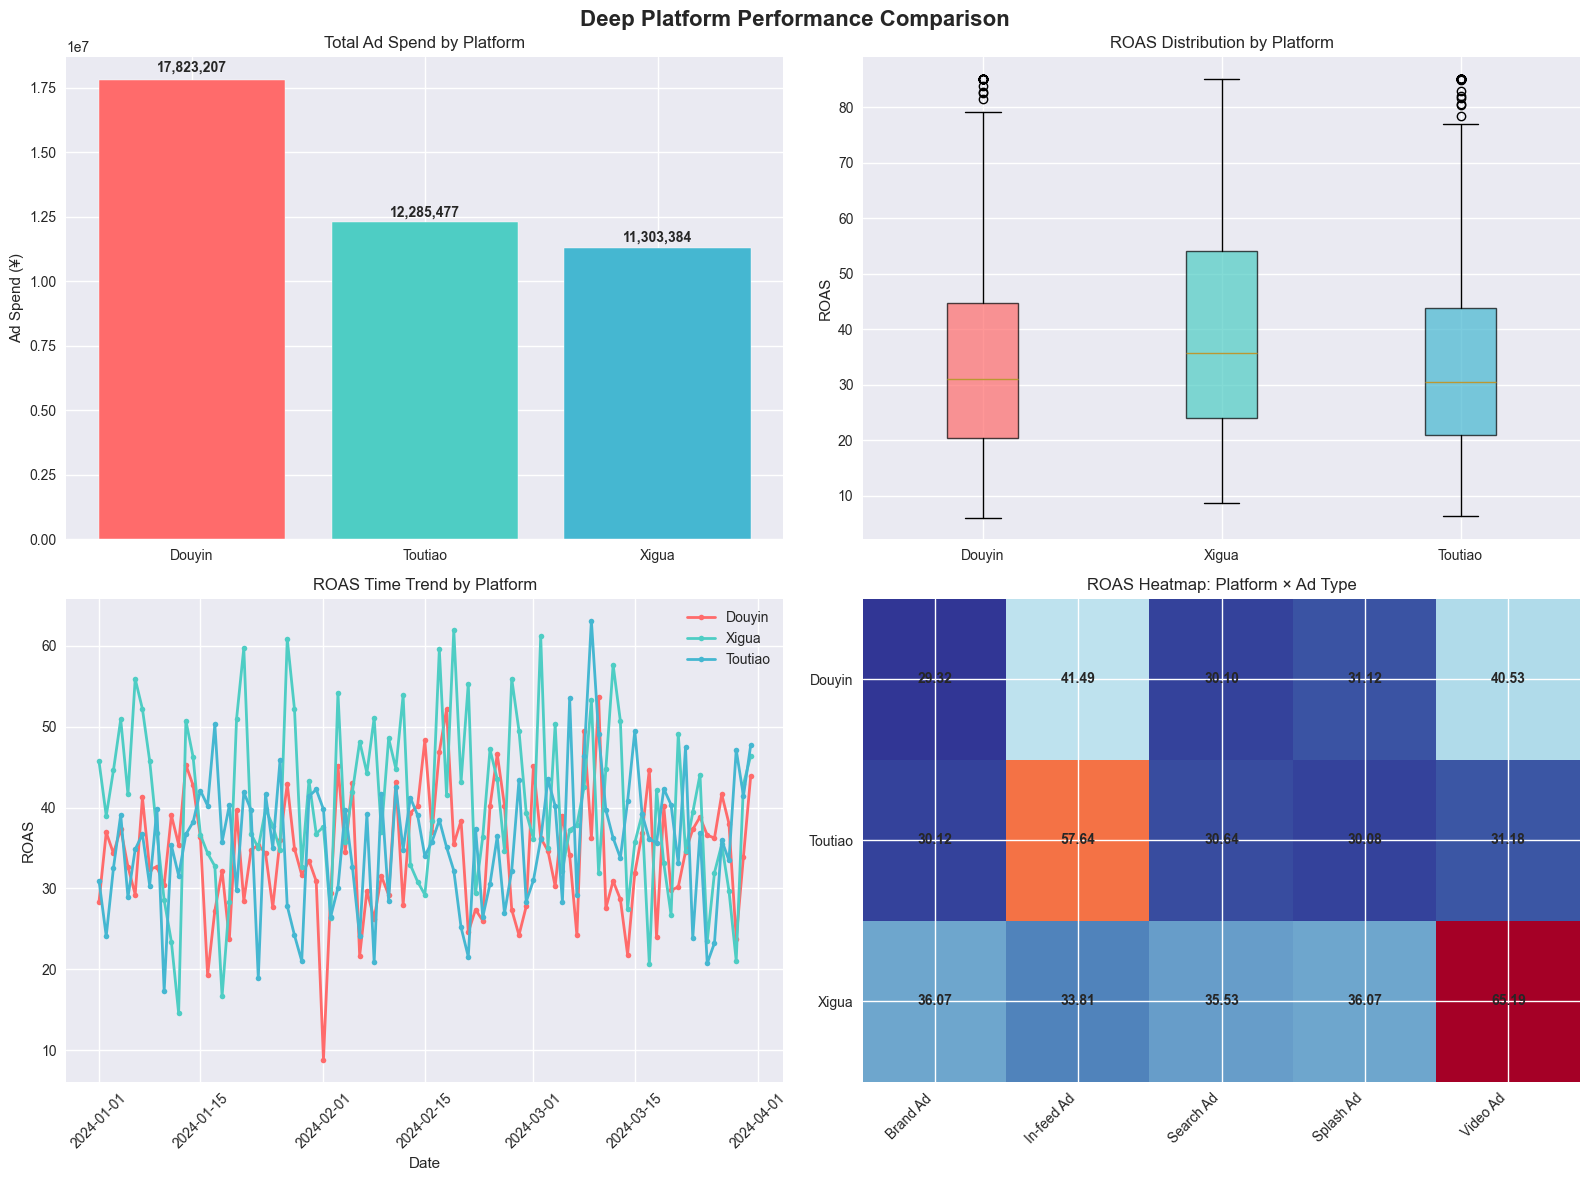

In [12]:
def platform_deep_analysis(df):
    """
    Comprehensive platform performance analysis
    """
    # 1. Core performance metrics
    platform_metrics = df.groupby('platform').agg({
        'ad_spend': ['sum', 'mean', 'std'],
        'impressions': 'sum',
        'clicks': 'sum', 
        'conversions': 'sum',
        'revenue': ['sum', 'mean'],
        'ctr': ['mean', 'std'],
        'cvr': ['mean', 'std'],
        'roas': ['mean', 'std', 'median'],
        'cpa': ['mean', 'std'],
        'cpm': 'mean'
    }).round(3)
    
    # 2. Time trend analysis
    platform_trends = df.groupby(['platform', 'date']).agg({
        'ad_spend': 'sum',
        'revenue': 'sum',
        'ctr': 'mean',
        'roas': 'mean'
    }).reset_index()
    
    # 3. Ad type performance by platform
    platform_ad_type = df.groupby(['platform', 'ad_type']).agg({
        'roas': 'mean',
        'ctr': 'mean',
        'cvr': 'mean',
        'ad_spend': 'sum'
    }).reset_index()
    
    return platform_metrics, platform_trends, platform_ad_type


# Run platform-level analysis
platform_metrics, platform_trends, platform_ad_type = platform_deep_analysis(df_enhanced)

print("=== Platform Key Metrics Comparison ===")
print("Ad Spend Statistics:")
print(platform_metrics['ad_spend'])
print("\nROAS Statistics:")
print(platform_metrics['roas'])
print("\nCTR Statistics:")  
print(platform_metrics['ctr'])


# Radar chart helper
def create_radar_chart(df):
    """
    Create normalized radar chart values for platform comparison
    """
    # Calculate platform-level averages
    platform_summary = df.groupby('platform').agg({
        'ctr': 'mean',
        'cvr': 'mean', 
        'roas': 'mean',
        'avg_order_value': 'mean'
    })
    
    # Add inverse metrics (smaller is better → invert)
    platform_summary['cpa_norm'] = 1 / df.groupby('platform')['cpa'].mean()
    platform_summary['cpm_norm'] = 1 / df.groupby('platform')['cpm'].mean()
    
    # Normalize to [0,1]
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    platform_summary_norm = pd.DataFrame(
        scaler.fit_transform(platform_summary),
        index=platform_summary.index,
        columns=platform_summary.columns
    )
    
    return platform_summary_norm


platform_radar = create_radar_chart(df_enhanced)


# Visualization: Deep Platform Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Deep Platform Performance Comparison', fontsize=16, fontweight='bold')

# 1. Total spend comparison
platform_spend = df_enhanced.groupby('platform')['ad_spend'].sum()
bars = axes[0, 0].bar(platform_spend.index, platform_spend.values,
                      color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
axes[0, 0].set_title('Total Ad Spend by Platform')
axes[0, 0].set_ylabel('Ad Spend (¥)')
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{height:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. ROAS distribution (boxplot)
platforms = df_enhanced['platform'].unique()
roas_data = [df_enhanced[df_enhanced['platform'] == platform]['roas'].values for platform in platforms]
bp = axes[0, 1].boxplot(roas_data, labels=platforms, patch_artist=True)
axes[0, 1].set_title('ROAS Distribution by Platform')
axes[0, 1].set_ylabel('ROAS')
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1'] 
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# 3. ROAS time trends
for i, platform in enumerate(platforms):
    platform_data = platform_trends[platform_trends['platform'] == platform]
    axes[1, 0].plot(platform_data['date'], platform_data['roas'], 
                    label=platform, linewidth=2, marker='o', markersize=4,
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1'][i])
axes[1, 0].set_title('ROAS Time Trend by Platform')
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('ROAS')
axes[1, 0].legend()
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Platform × Ad Type performance heatmap (ROAS)
heatmap_data = platform_ad_type.pivot(index='platform', columns='ad_type', values='roas')
im = axes[1, 1].imshow(heatmap_data.values, cmap='RdYlBu_r', aspect='auto')
axes[1, 1].set_title('ROAS Heatmap: Platform × Ad Type')
axes[1, 1].set_xticks(range(len(heatmap_data.columns)))
axes[1, 1].set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
axes[1, 1].set_yticks(range(len(heatmap_data.index)))
axes[1, 1].set_yticklabels(heatmap_data.index)

# Add numeric labels inside heatmap
for i in range(len(heatmap_data.index)):
    for j in range(len(heatmap_data.columns)):
        if not pd.isna(heatmap_data.iloc[i, j]):
            axes[1, 1].text(j, i, f'{heatmap_data.iloc[i, j]:.2f}',
                           ha='center', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


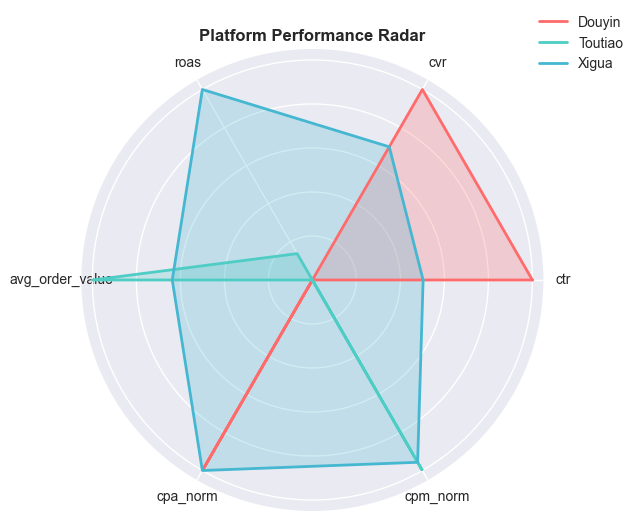

In [13]:
# 5. Radar chart for platform comparison
def plot_radar(ax, data, title):
    categories = list(data.columns)
    N = len(categories)

    # Radar angles
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close loop

    # Plot each platform
    for idx, platform in enumerate(data.index):
        values = data.loc[platform].tolist()
        values += values[:1]  # close loop
        ax.plot(angles, values, linewidth=2, 
                label=platform,
                color=['#FF6B6B', '#4ECDC4', '#45B7D1'][idx])
        ax.fill(angles, values, alpha=0.25, 
                color=['#FF6B6B', '#4ECDC4', '#45B7D1'][idx])

    # Category labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticklabels([])  # hide radial scale
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))

fig, ax = plt.subplots(figsize=(6,6), subplot_kw=dict(polar=True))
plot_radar(ax, platform_radar, "Platform Performance Radar")
plt.show()

## Platform Performance Analysis Insights

- **Overall Insights**
  - **Douyin**: Strong in engagement (highest CTR) and main spend focus, but ROAS is only average.
  - **Xigua**: Best efficiency (highest ROAS) despite lowest budget allocation → clear opportunity to reallocate more spend here.
  - **Toutiao**: Lags behind both in CTR and ROAS; its role may be more supportive or for audience diversification, but not as efficient as Douyin/Xigua.

- **Strategic Recommendations**
  - **Reallocate Budget to Xigua**. Increase budget share for Xigua campaigns to leverage its superior ROAS and efficiency. Test gradual scaling to validate whether higher spend maintains performance.
  - **Optimize Douyin Conversion Funnel**. Since Douyin already has the strongest CTR, focus on improving conversion rates post-click (e.g., landing page optimization, audience retargeting) to lift its ROAS closer to Xigua.
  - Reevaluate Toutiao’s Role. Limit Toutiao spend to experimental or niche audience campaigns.

## 4.3. Statistical Significance Testing

In [14]:
from scipy import stats
import itertools

def statistical_significance_testing(df):
    """
    Perform multi-dimensional statistical significance testing
    """
    results = {}
    
    # 1. ROAS differences across platforms (ANOVA)
    platform_groups = [df[df['platform'] == platform]['roas'].values 
                      for platform in df['platform'].unique()]
    f_stat, p_value = stats.f_oneway(*platform_groups)
    results['platform_roas_anova'] = {'f_statistic': f_stat, 'p_value': p_value}
    
    # 2. Pairwise platform comparisons (t-test)
    platforms = df['platform'].unique()
    platform_comparisons = {}
    for platform1, platform2 in itertools.combinations(platforms, 2):
        group1 = df[df['platform'] == platform1]['roas'].values
        group2 = df[df['platform'] == platform2]['roas'].values
        t_stat, p_val = stats.ttest_ind(group1, group2)
        platform_comparisons[f'{platform1} vs {platform2}'] = {
            't_statistic': t_stat, 'p_value': p_val,
            'significant': p_val < 0.05
        }
    results['platform_pairwise'] = platform_comparisons
    
    # 3. CTR differences across generations (ANOVA)
    generation_groups = [df[df['generation'] == gen]['ctr'].values 
                        for gen in df['generation'].unique()]
    f_stat, p_value = stats.f_oneway(*generation_groups)
    results['generation_ctr_anova'] = {'f_statistic': f_stat, 'p_value': p_value}
    
    # 4. Weekend vs Weekday ROAS comparison
    weekend_roas = df[df['is_weekend'] == 1]['roas'].values
    weekday_roas = df[df['is_weekend'] == 0]['roas'].values
    t_stat, p_value = stats.ttest_ind(weekend_roas, weekday_roas)
    results['weekend_vs_weekday'] = {
        't_statistic': t_stat, 'p_value': p_value,
        'weekend_mean': weekend_roas.mean(),
        'weekday_mean': weekday_roas.mean(),
        'significant': p_value < 0.05
    }
    
    # 5. Correlation analysis
    correlations = {}
    metrics = ['ad_spend', 'ctr', 'cvr', 'roas', 'avg_order_value']
    for metric1, metric2 in itertools.combinations(metrics, 2):
        if metric1 in df.columns and metric2 in df.columns:
            corr, p_val = stats.pearsonr(df[metric1], df[metric2])
            correlations[f'{metric1} vs {metric2}'] = {
                'correlation': corr, 'p_value': p_val,
                'significant': p_val < 0.05
            }
    results['correlations'] = correlations
    
    return results

# Run the statistical tests
stat_results = statistical_significance_testing(df_enhanced)

print("=== Statistical Significance Testing Results ===")
print(f"\n1. ROAS differences across platforms (ANOVA):")
print(f"   F-statistic: {stat_results['platform_roas_anova']['f_statistic']:.4f}")
print(f"   P-value: {stat_results['platform_roas_anova']['p_value']:.4f}")
print(f"   Conclusion: {'Significant differences exist' if stat_results['platform_roas_anova']['p_value'] < 0.05 else 'No significant differences'}")

print(f"\n2. Pairwise platform comparison results:")
for comparison, result in stat_results['platform_pairwise'].items():
    print(f"   {comparison}: P-value={result['p_value']:.4f}, {'Significant' if result['significant'] else 'Not significant'}")

print(f"\n3. CTR differences across generations (ANOVA):")
print(f"   F-statistic: {stat_results['generation_ctr_anova']['f_statistic']:.4f}")
print(f"   P-value: {stat_results['generation_ctr_anova']['p_value']:.4f}")
print(f"   Conclusion: {'Significant differences exist' if stat_results['generation_ctr_anova']['p_value'] < 0.05 else 'No significant differences'}")

print(f"\n4. Weekend vs Weekday ROAS comparison:")
weekend_result = stat_results['weekend_vs_weekday']
print(f"   Weekend mean ROAS: {weekend_result['weekend_mean']:.3f}")
print(f"   Weekday mean ROAS: {weekend_result['weekday_mean']:.3f}")
print(f"   P-value: {weekend_result['p_value']:.4f}")
print(f"   Conclusion: {'Weekend ROAS is significantly higher' if weekend_result['significant'] and weekend_result['weekend_mean'] > weekend_result['weekday_mean'] else 'No significant difference'}")

print(f"\n5. Key correlation analysis:")
for correlation, result in stat_results['correlations'].items():
    if result['significant']:
        print(f"   {correlation}: r={result['correlation']:.3f}, P-value={result['p_value']:.4f} (Significant)")

# Effect size analysis
def calculate_effect_sizes(df):
    """
    Calculate effect sizes (Cohen's d) for platform ROAS comparisons
    """
    effect_sizes = {}
    
    platforms = df['platform'].unique()
    for platform1, platform2 in itertools.combinations(platforms, 2):
        group1 = df[df['platform'] == platform1]['roas'].values
        group2 = df[df['platform'] == platform2]['roas'].values
        
        pooled_std = np.sqrt(((len(group1) - 1) * group1.var() + 
                             (len(group2) - 1) * group2.var()) / 
                            (len(group1) + len(group2) - 2))
        cohen_d = (group1.mean() - group2.mean()) / pooled_std
        
        effect_sizes[f'{platform1} vs {platform2}'] = {
            'cohens_d': cohen_d,
            'magnitude': 'small' if abs(cohen_d) < 0.5 else 'medium' if abs(cohen_d) < 0.8 else 'large'
        }
    
    return effect_sizes

effect_sizes = calculate_effect_sizes(df_enhanced)
print(f"\n=== Effect Size Analysis (Cohen's d) ===")
for comparison, result in effect_sizes.items():
    print(f"{comparison}: d={result['cohens_d']:.3f} ({result['magnitude']} effect)")


=== Statistical Significance Testing Results ===

1. ROAS differences across platforms (ANOVA):
   F-statistic: 21.9774
   P-value: 0.0000
   Conclusion: Significant differences exist

2. Pairwise platform comparison results:
   Douyin vs Xigua: P-value=0.0000, Significant
   Douyin vs Toutiao: P-value=0.3626, Not significant
   Xigua vs Toutiao: P-value=0.0000, Significant

3. CTR differences across generations (ANOVA):
   F-statistic: 522.4192
   P-value: 0.0000
   Conclusion: Significant differences exist

4. Weekend vs Weekday ROAS comparison:
   Weekend mean ROAS: 41.371
   Weekday mean ROAS: 35.274
   P-value: 0.0000
   Conclusion: Weekend ROAS is significantly higher

5. Key correlation analysis:
   ad_spend vs ctr: r=0.046, P-value=0.0494 (Significant)
   ad_spend vs roas: r=-0.055, P-value=0.0200 (Significant)
   ad_spend vs avg_order_value: r=-0.058, P-value=0.0131 (Significant)
   ctr vs cvr: r=0.230, P-value=0.0000 (Significant)
   ctr vs roas: r=0.355, P-value=0.0000 (Sign

## Statistical Testing Insights

## Overall Insights:
- **Platform Performance Differences**
  - Significant ROAS differences exist across platforms.
  - Effect sizes (Cohen’s d) are small across all pairs. Although Xigua demonstrates a consistent ROAS advantage over the other two platforms, the actual gap in magnitude is not very large.

- **Generational Engagement**
  - CTR varies significantly across generations.
  - Implication: Audience generation is a critical segmentation factor for ad engagement; tailoring creatives and targeting strategies by generation is likely to yield strong benefits.

- **Temporal Performance**
  - Weekend ROAS is significantly higher.
  - Implication: Allocate more budget or scale campaigns on weekends when users are more responsive and returns are stronger.

- **Correlation Patterns**
  - CVR has the strongest correlation with ROAS. Conversion rate is the single most powerful driver of ROAS.

## Strategic Takeaways：
- Prioritize Xigua for efficiency gains, but effect sizes are modest — cannot over-shift budget without monitoring marginal returns.
- **Leverage weekends** as high-performance windows; test higher weekend bids and delivery pacing.
- **Focus on boosting CVR** (through landing page optimization, retargeting, and user journey improvements), as it’s the strongest lever for ROAS.
- **Segment by generation** for ad creatives and messaging; generational targeting clearly matters for CTR.

## 4.4. Machine Learning Clustering Analysis

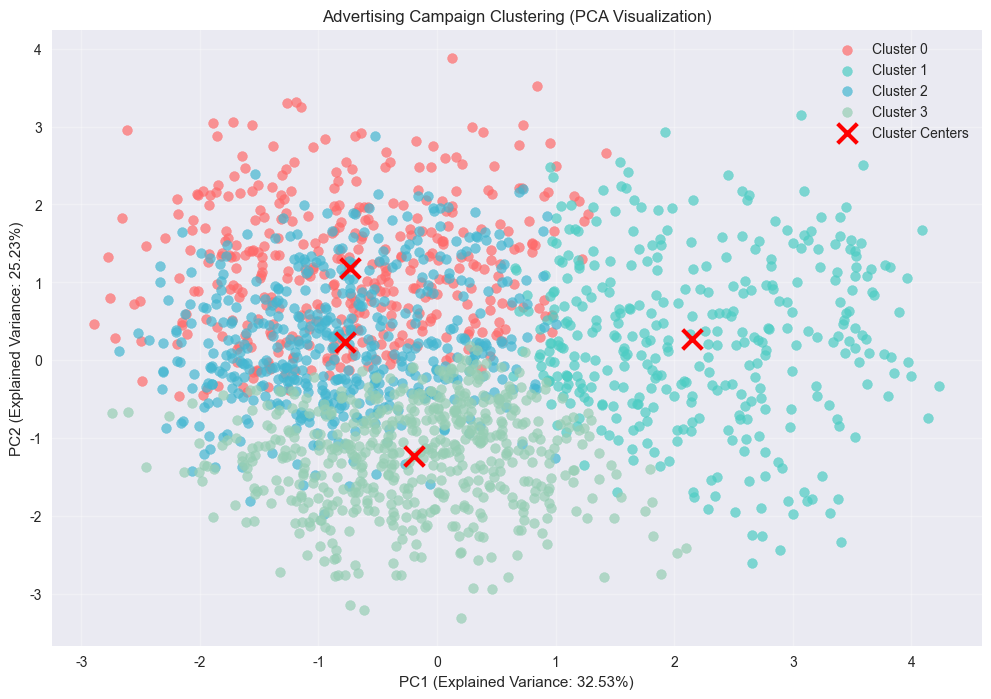

=== Clustering Analysis Results ===
PCA Cumulative Explained Variance: 57.76%

Cluster Feature Analysis:

Cluster 0 - High-Value Large Investment:
  Sample Count: 390
  Avg Spend: 35162 CNY
  Avg CTR: 0.028
  Avg CVR: 0.094
  Avg ROAS: 27.39
  Main Platform: <lambda>    Douyin
Name: 0, dtype: object
  Main Generation: <lambda>    Gen Z
Name: 0, dtype: object

Cluster 1 - High-Value Large Investment:
  Sample Count: 363
  Avg Spend: 21218 CNY
  Avg CTR: 0.030
  Avg CVR: 0.122
  Avg ROAS: 69.30
  Main Platform: <lambda>    Xigua
Name: 1, dtype: object
  Main Generation: <lambda>    Millennials
Name: 1, dtype: object

Cluster 2 - High-ROI Precision Investment:
  Sample Count: 500
  Avg Spend: 16018 CNY
  Avg CTR: 0.027
  Avg CVR: 0.079
  Avg ROAS: 25.69
  Main Platform: <lambda>    Xigua
Name: 2, dtype: object
  Main Generation: <lambda>    Gen Z
Name: 2, dtype: object

Cluster 3 - High-Value Large Investment:
  Sample Count: 554
  Avg Spend: 21639 CNY
  Avg CTR: 0.019
  Avg CVR: 0.080
  

In [15]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def perform_clustering_analysis(df):
    """
    Perform clustering analysis on advertising campaigns
    """
    # Select clustering features
    clustering_features = ['ad_spend', 'ctr', 'cvr', 'roas', 'avg_order_value', 'cpm']
    
    # Data preprocessing
    X = df[clustering_features].copy()
    X = X.fillna(X.mean())  # Handle missing values
    
    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform clustering with fixed cluster number (K=4)
    optimal_k = 4
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add clustering results to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Analyze cluster characteristics
    cluster_analysis = df_clustered.groupby('cluster').agg({
        'ad_spend': ['mean', 'std'],
        'ctr': 'mean',
        'cvr': 'mean',
        'roas': 'mean',
        'avg_order_value': 'mean',
        'platform': lambda x: x.mode().iloc[0],  # Most frequent platform
        'generation': lambda x: x.mode().iloc[0]  # Most frequent generation
    }).round(3)
    
    # PCA dimensionality reduction for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    plt.figure(figsize=(12, 8))
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for i in range(optimal_k):
        cluster_points = X_pca[cluster_labels == i]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   c=colors[i], label=f'Cluster {i}', alpha=0.7, s=50)
    
    # Plot cluster centers
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
               c='red', marker='x', s=200, linewidths=3, label='Cluster Centers')
    
    plt.xlabel(f'PC1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'PC2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.title('Advertising Campaign Clustering (PCA Visualization)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Assign names to clusters
    cluster_names = {}
    for i in range(optimal_k):
        cluster_data = cluster_analysis.loc[i]
        
        if cluster_data[('roas', 'mean')] > 2.5:
            if cluster_data[('ad_spend', 'mean')] > 20000:
                cluster_names[i] = 'High-Value Large Investment'
            else:
                cluster_names[i] = 'High-ROI Precision Investment'
        elif cluster_data[('ctr', 'mean')] > 0.03:
            cluster_names[i] = 'High Exposure, Low Conversion'
        else:
            cluster_names[i] = 'Low-Performance Investment'
    
    return df_clustered, cluster_analysis, cluster_names, pca.explained_variance_ratio_

# Run clustering analysis
df_clustered, cluster_analysis, cluster_names, explained_variance = perform_clustering_analysis(df_enhanced)

print("=== Clustering Analysis Results ===")
print(f"PCA Cumulative Explained Variance: {sum(explained_variance):.2%}")
print("\nCluster Feature Analysis:")
for i, name in cluster_names.items():
    print(f"\nCluster {i} - {name}:")
    print(f"  Sample Count: {len(df_clustered[df_clustered['cluster'] == i])}")
    print(f"  Avg Spend: {cluster_analysis.loc[i, ('ad_spend', 'mean')]:.0f} CNY")
    print(f"  Avg CTR: {cluster_analysis.loc[i, ('ctr', 'mean')]:.3f}")
    print(f"  Avg CVR: {cluster_analysis.loc[i, ('cvr', 'mean')]:.3f}")
    print(f"  Avg ROAS: {cluster_analysis.loc[i, ('roas', 'mean')]:.2f}")
    print(f"  Main Platform: {cluster_analysis.loc[i, 'platform']}")
    print(f"  Main Generation: {cluster_analysis.loc[i, 'generation']}")


# Cluster business value analysis
cluster_value = df_clustered.groupby('cluster').agg({
    'ad_spend': 'sum',
    'revenue': 'sum',
    'conversions': 'sum'
}).reset_index()

cluster_value['roi'] = (cluster_value['revenue'] - cluster_value['ad_spend']) / cluster_value['ad_spend']
cluster_value['conversion_rate'] = cluster_value['conversions'] / df_clustered.groupby('cluster')['clicks'].sum().values

print(f"\n=== Cluster Business Value Analysis ===")
for i, row in cluster_value.iterrows():
    cluster_id = row['cluster']
    print(f"\n{cluster_names[cluster_id]}:")
    print(f"  Total Spend: {row['ad_spend']:,.0f} CNY")
    print(f"  Total Revenue: {row['revenue']:,.0f} CNY") 
    print(f"  ROI: {row['roi']:.2%}")
    print(f"  Total Conversions: {row['conversions']:,.0f}")


<h2 style="text-align:center; color:white;">Clustering Analysis of Advertising Campaigns</h2>

<div style="display: flex; justify-content: space-between; flex-wrap: nowrap;">

  <div style="background: linear-gradient(135deg, #FF6B6B, #FF8C69); 
              padding: 20px; border-radius: 15px; width: 23%; color: white; text-align: center; margin-bottom: 20px;">
    <h3>Cluster 0</h3>
    <p><b>High-Value Large Investment</b></p>
    <p><b>Platform:</b> Douyin<br><b>Audience:</b> Gen Z</p>
    <p><b>CTR:</b> 2.8%<br><b>CVR:</b> 9.4%<br><b>ROAS:</b> 27.39</p>
    <p style="font-size:14px;">Large spend on Douyin for Gen Z; strong revenue but efficiency moderate.</p>
  </div>

  <div style="background: linear-gradient(135deg, #4ECDC4, #20B2AA); 
              padding: 20px; border-radius: 15px; width: 23%; color: white; text-align: center; margin-bottom: 20px;">
    <h3>Cluster 1</h3>
    <p><b>Top Performer</b></p>
    <p><b>Platform:</b> Xigua<br><b>Audience:</b> Millennials</p>
    <p><b>CTR:</b> 3.0%<br><b>CVR:</b> 12.2%<br><b>ROAS:</b> 69.30</p>
    <p style="font-size:14px;">Highest efficiency (ROAS 69.3); should be prioritized for scaling.</p>
  </div>

  <div style="background: linear-gradient(135deg, #45B7D1, #1E90FF); 
              padding: 20px; border-radius: 15px; width: 23%; color: white; text-align: center; margin-bottom: 20px;">
    <h3>Cluster 2</h3>
    <p><b>High-ROI Precision Investment</b></p>
    <p><b>Platform:</b> Xigua<br><b>Audience:</b> Gen Z</p>
    <p><b>CTR:</b> 2.7%<br><b>CVR:</b> 7.9%<br><b>ROAS:</b> 25.69</p>
    <p style="font-size:14px;">Smaller but efficient; stable returns, good for audience expansion.</p>
  </div>

  <div style="background: linear-gradient(135deg, #96CEB4, #3CB371); 
              padding: 20px; border-radius: 15px; width: 23%; color: white; text-align: center; margin-bottom: 20px;">
    <h3>Cluster 3</h3>
    <p><b>High-Value Large Investment</b></p>
    <p><b>Platform:</b> Toutiao<br><b>Audience:</b> Baby Boomers</p>
    <p><b>CTR:</b> 1.9%<br><b>CVR:</b> 8.0%<br><b>ROAS:</b> 32.89</p>
    <p style="font-size:14px;">Lower CTR but decent ROAS; valuable for older demographics.</p>
  </div>

</div>

---

<h3 style="color:white;">📌 Business Insights & Recommendations</h3>

<ul>
  <li><b>Cluster 1</b>: Clear top performer (ROAS 69.3, highest CVR). <span style="color:#4ECDC4; font-weight:bold;">Prioritize budget allocation here</span>.</li>
  <li><b>Cluster 3</b>: Solid efficiency (ROAS 32.9) driven by Baby Boomers on Toutiao. <span style="color:#45B7D1; font-weight:bold;">Keep as secondary focus</span>.</li>
  <li><b>Cluster 0</b>: High spend but relatively lower efficiency (ROAS 27.4). <span style="color:#FF6B6B; font-weight:bold;">Needs creative/platform optimization</span>.</li>
  <li><b>Cluster 2</b>: Lower budget, stable efficiency (ROAS 25.7). <span style="color:#FFD700; font-weight:bold;">Use for low-cost audience expansion & testing</span>.</li>
</ul>


# 5. Time Series Analysis and Prediction Models

## 5.1. Time Series Trend Decomposition

> **Note:** Data is not suitable for predictive TS models, decomposition is for EDA only.

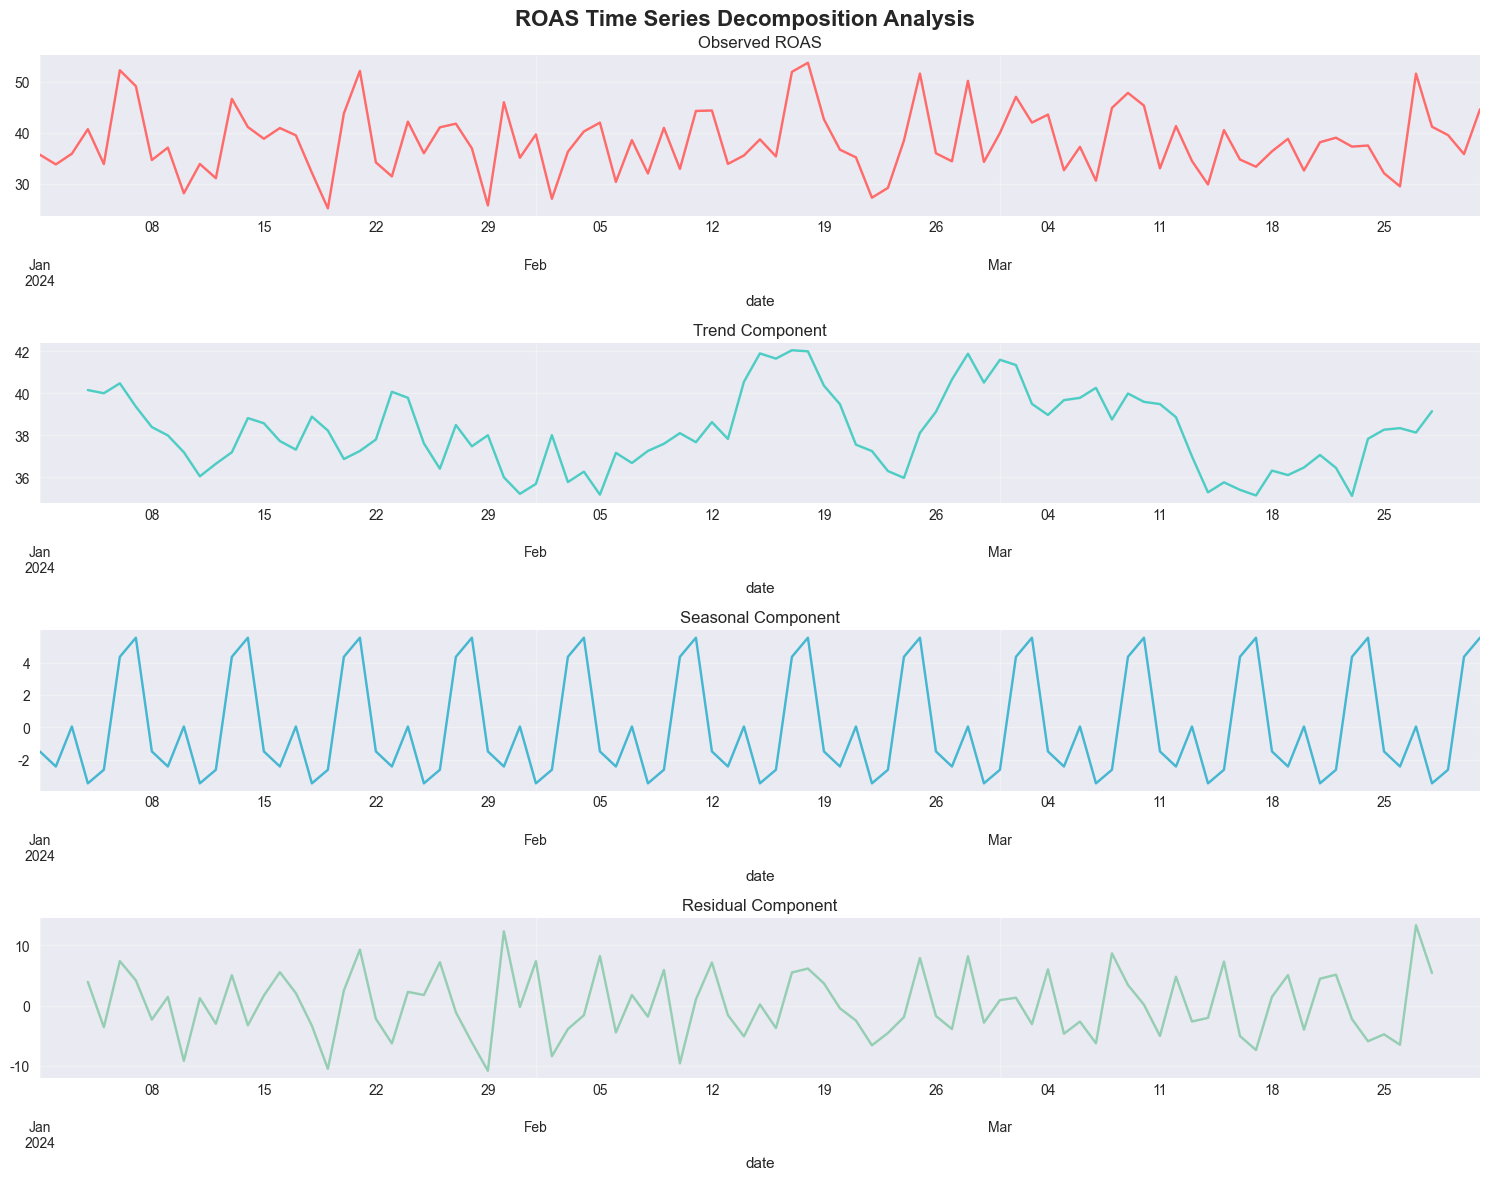

=== Time Series Feature Analysis ===
Date range: 2024-01-01 00:00:00 to 2024-03-31 00:00:00
Total days: 91 days
Overall ROAS trend: Downward
Trend start value: 40.155
Trend end value: 39.148
Seasonal fluctuation range: -3.444 to 5.527

=== Metric Stability Analysis (Coefficient of Variation) ===
ad_spend: 0.210 (Moderate fluctuation)
revenue: 0.267 (Moderate fluctuation)
roas: 0.169 (Stable)
ctr: 0.095 (Stable)


In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

def time_series_analysis(df):
    """
    Deep time series analysis
    """
    # Prepare time series data
    daily_data = df.groupby('date').agg({
        'ad_spend': 'sum',
        'revenue': 'sum', 
        'impressions': 'sum',
        'clicks': 'sum',
        'conversions': 'sum'
    }).reset_index()
    
    # Calculate derived metrics
    daily_data['ctr'] = daily_data['clicks'] / daily_data['impressions']
    daily_data['cvr'] = daily_data['conversions'] / daily_data['clicks']
    daily_data['roas'] = daily_data['revenue'] / daily_data['ad_spend']
    daily_data['roi'] = (daily_data['revenue'] - daily_data['ad_spend']) / daily_data['ad_spend']
    
    # Set date as index
    daily_data.set_index('date', inplace=True)
    
    # Time series decomposition (example: ROAS)
    decomposition = seasonal_decompose(daily_data['roas'], model='additive', period=7)
    
    # Visualization of decomposition results
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    fig.suptitle('ROAS Time Series Decomposition Analysis', fontsize=16, fontweight='bold')
    
    # Observed series
    decomposition.observed.plot(ax=axes[0], title='Observed ROAS', color='#FF6B6B')
    axes[0].grid(True, alpha=0.3)
    
    # Trend component
    decomposition.trend.plot(ax=axes[1], title='Trend Component', color='#4ECDC4')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal component
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='#45B7D1')
    axes[2].grid(True, alpha=0.3)
    
    # Residual component
    decomposition.resid.plot(ax=axes[3], title='Residual Component', color='#96CEB4')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return daily_data, decomposition

# Run time series analysis
daily_ts, decomposition = time_series_analysis(df_enhanced)

print("=== Time Series Feature Analysis ===")
print(f"Date range: {daily_ts.index.min()} to {daily_ts.index.max()}")
print(f"Total days: {len(daily_ts)} days")

# Trend analysis
trend_data = decomposition.trend.dropna()
if trend_data.iloc[-1] > trend_data.iloc[0]:
    trend_direction = "Upward"
else:
    trend_direction = "Downward"

print(f"Overall ROAS trend: {trend_direction}")
print(f"Trend start value: {trend_data.iloc[0]:.3f}")
print(f"Trend end value: {trend_data.iloc[-1]:.3f}")

# Seasonal analysis
seasonal_data = decomposition.seasonal.dropna()
seasonal_max = seasonal_data.max()
seasonal_min = seasonal_data.min()
print(f"Seasonal fluctuation range: {seasonal_min:.3f} to {seasonal_max:.3f}")

# Coefficient of variation for each metric
cv_metrics = {}
for col in ['ad_spend', 'revenue', 'roas', 'ctr']:
    cv = daily_ts[col].std() / daily_ts[col].mean()
    cv_metrics[col] = cv

print(f"\n=== Metric Stability Analysis (Coefficient of Variation) ===")
for metric, cv in cv_metrics.items():
    stability = "Stable" if cv < 0.2 else "Moderate fluctuation" if cv < 0.5 else "High fluctuation"
    print(f"{metric}: {cv:.3f} ({stability})")


## We find:

- **ROAS Trend**: The overall ROAS shows a *slight downward trend* over the observed period (from **40.16** to **39.15**).  
- **Seasonality**: Clear *weekly seasonal patterns* exist, with fluctuations ranging approximately from **-3.44** to **+5.53** around the baseline.  
- **Stability**:  
  - **ROAS** and **CTR** are relatively *stable* (low variation).  
  - **Ad spend** and **revenue** exhibit *moderate fluctuations*, suggesting campaign-level adjustments or external shocks.  


## 5.2. Predictive Model

> **Note:** Due to dataset noise, baseline models have limited explanatory power. They are more useful for **trend references** than precise forecasts — e.g., to **estimate conversions** under different setups or identify **key drivers** (platform, generation) — rather than for single-point predictions.



['ad_spend', 'is_weekend', 'platform_Toutiao', 'platform_Xigua', 'ad_type_In-feed Ad', 'ad_type_Search Ad', 'ad_type_Splash Ad', 'ad_type_Video Ad', 'month_name_January', 'month_name_March', 'weekday_name_Monday', 'weekday_name_Saturday', 'weekday_name_Sunday', 'weekday_name_Thursday', 'weekday_name_Tuesday', 'weekday_name_Wednesday', 'generation_Gen X', 'generation_Gen Z', 'generation_Millennials']

=== Build revenue prediction model ===

Linear Regression Performance:
  R²: 0.4309
  MAE: 352089.7264
  MAPE: 59.3170%

Random Forest Performance:
  R²: 0.5168
  MAE: 332458.3079
  MAPE: 47.8381%

Top 10 important features for revenue:
  ad_spend: 0.5027
  platform_Xigua: 0.0660
  generation_Millennials: 0.0631
  generation_Gen X: 0.0614
  ad_type_Video Ad: 0.0557
  ad_type_In-feed Ad: 0.0541
  platform_Toutiao: 0.0354
  is_weekend: 0.0199
  weekday_name_Sunday: 0.0178
  month_name_March: 0.0174

=== Build conversions prediction model ===

Linear Regression Performance:
  R²: 0.5463
  MAE

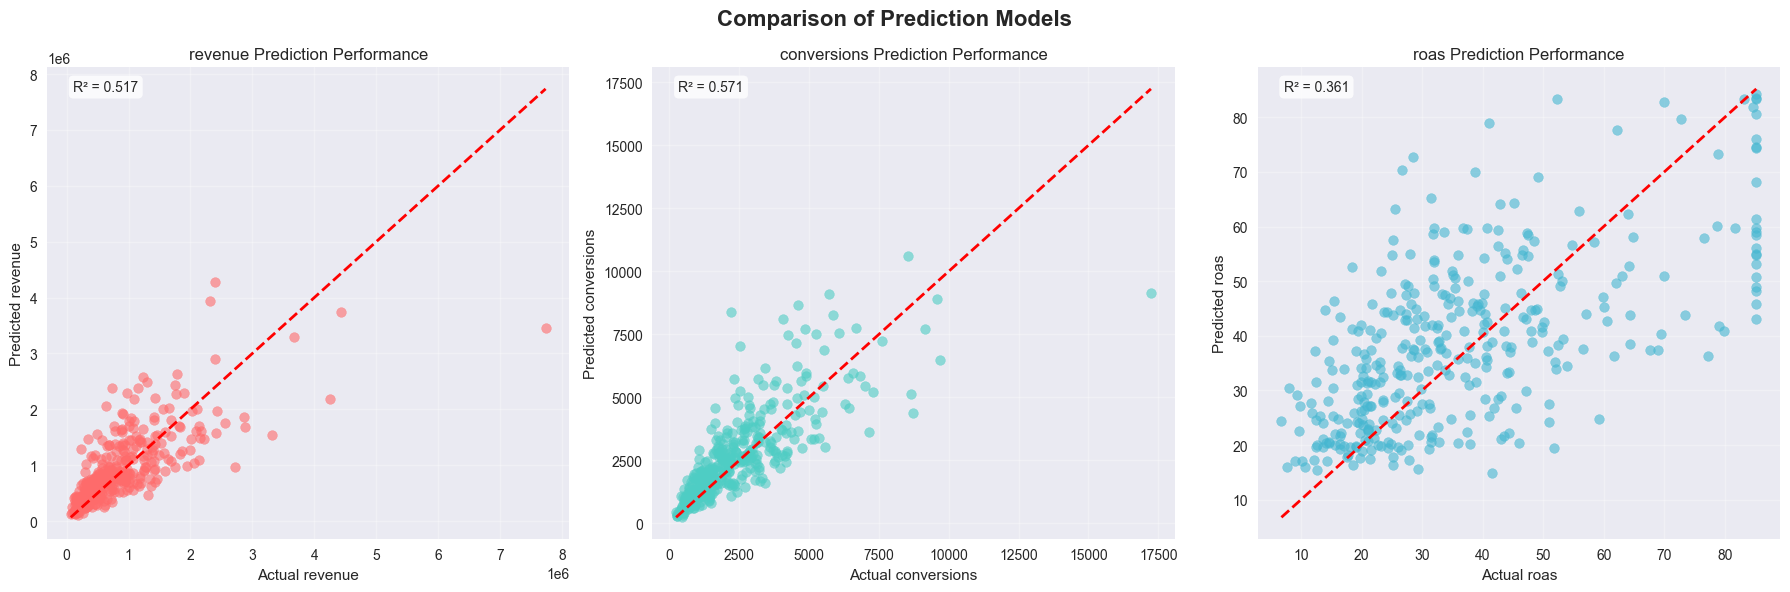

In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

def build_prediction_models(df):
    """
    Build multiple prediction models
    """
    # Define feature and target columns
    feature_columns = ['ad_spend', 'platform', 'ad_type', 'generation', 'weekday', 'is_weekend', 'month']
    target_columns = ['revenue', 'conversions', 'roas']
    
    # Copy dataframe
    df_model = df.copy()

    # Detect categorical columns automatically (object or category dtypes)
    categorical_columns = df_model.select_dtypes(include=['object', 'category']).columns.tolist()

    # One-hot encode categorical columns
    if categorical_columns:
        df_model = pd.get_dummies(df_model, columns=categorical_columns, drop_first=True)
    
    # Select features
    feature_cols = [col for col in df_model.columns 
                    if any(fc in col for fc in feature_columns) and col not in target_columns]
    for col in ['cpc_vs_platform_avg', 'weekday', 'month']: feature_cols.remove(col)
    
    print(feature_cols)
    
    models_results = {}
    
    for target in target_columns:
        if target not in df_model.columns:
            continue
            
        print(f"\n=== Build {target} prediction model ===")
        
        # Prepare data
        X = df_model[feature_cols].fillna(0)
        y = df_model[target].fillna(0)
        
        # Split into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, shuffle=True
        )
        
        # Model 1: Linear Regression
        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)
        lr_pred = lr_model.predict(X_test)
        
        # Model 2: Random Forest
        rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_model.fit(X_train, y_train)
        rf_pred = rf_model.predict(X_test)
        
        # Evaluate models
        models = {
            'Linear Regression': {'model': lr_model, 'predictions': lr_pred},
            'Random Forest': {'model': rf_model, 'predictions': rf_pred}
        }
        
        model_performance = {}
        
        for model_name, model_info in models.items():
            pred = model_info['predictions']
            
            r2 = r2_score(y_test, pred)
            mae = mean_absolute_error(y_test, pred)
            mse = mean_squared_error(y_test, pred)
            mape = mean_absolute_percentage_error(y_test, pred)
            
            model_performance[model_name] = {
                'R²': r2,
                'MAE': mae,
                'MSE': mse,
                'MAPE': mape
            }
            
            print(f"\n{model_name} Performance:")
            print(f"  R²: {r2:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  MAPE: {mape:.4%}")
        
        # Feature importance analysis (Random Forest)
        if target in ['revenue', 'conversions']:
            feature_importance = pd.DataFrame({
                'feature': feature_cols,
                'importance': rf_model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print(f"\nTop 10 important features for {target}:")
            for i, row in feature_importance.head(10).iterrows():
                print(f"  {row['feature']}: {row['importance']:.4f}")
        
        models_results[target] = {
            'models': models,
            'performance': model_performance,
            'test_data': (X_test, y_test),
            'feature_importance': feature_importance if target in ['revenue', 'conversions'] else None
        }
    
    return models_results

# Build prediction models
prediction_results = build_prediction_models(df_enhanced)

# Visualize prediction results
def visualize_predictions(results):
    """
    Visualize prediction results
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle('Comparison of Prediction Models', fontsize=16, fontweight='bold')
    
    targets = ['revenue', 'conversions', 'roas']
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    for i, target in enumerate(targets):
        if target not in results:
            continue
            
        X_test, y_test = results[target]['test_data']
        
        # Random Forest predictions
        rf_pred = results[target]['models']['Random Forest']['predictions']
        
        # Plot actual vs predicted values
        axes[i].scatter(y_test, rf_pred, alpha=0.6, color=colors[i])
        
        # Plot perfect prediction line
        min_val = min(y_test.min(), rf_pred.min())
        max_val = max(y_test.max(), rf_pred.max())
        axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
        
        axes[i].set_xlabel(f'Actual {target}')
        axes[i].set_ylabel(f'Predicted {target}')
        axes[i].set_title(f'{target} Prediction Performance')
        axes[i].grid(True, alpha=0.3)
        
        # Add R² value
        r2 = results[target]['performance']['Random Forest']['R²']
        axes[i].text(0.05, 0.95, f'R² = {r2:.3f}', transform=axes[i].transAxes,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

visualize_predictions(prediction_results)


### Usefulness of Predictive Models

In practical terms, these predictive models allow us to input a new set of advertising campaign parameters and estimate the expected **Revenue**, **Conversions**, and **ROAS**. This provides several actionable benefits:

1. **Campaign Optimization**  
   - By testing different combinations of ad spend, platforms, and formats, the model can predict the corresponding Revenue/ROAS.  
   - This helps identify the most effective allocation of budget to maximize returns.

2. **Performance Forecasting**  
   - Before launching a campaign, the model can provide an estimate of its potential revenue and conversions.  
   - This enables setting realistic expectations and benchmarks for performance evaluation.

3. **Key Driver Analysis**  
   - Using Random Forest feature importance, we can identify which factors (e.g., platform, ad type, generation) have the strongest influence on outcomes.  
   - This guides data-driven decisions on where to focus investment and optimization efforts.


# 6. Advanced Analytical Techniques

## 6.1. Attribution Analysis Model

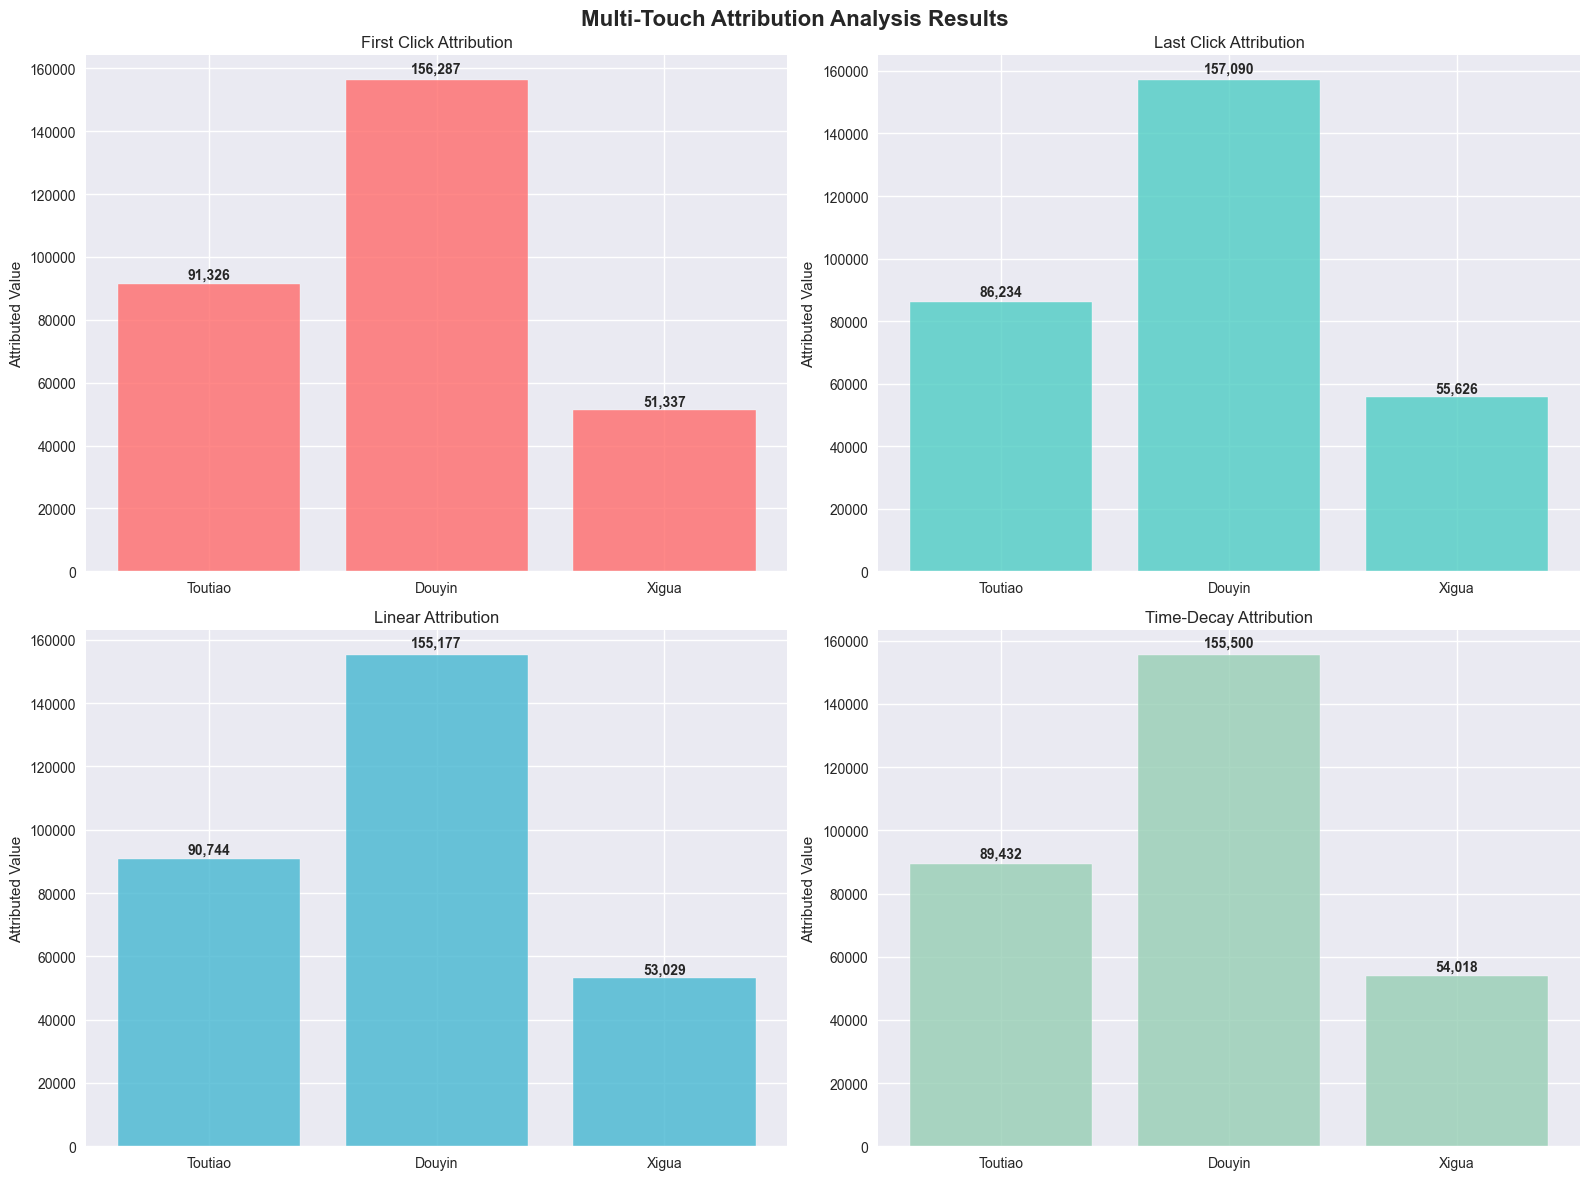


Platform attribution values under different models:
         first_click  last_click    linear  time_decay
Toutiao      91326.0     86234.0   90744.0     89432.0
Douyin      156287.0    157090.0  155177.0    155500.0
Xigua        51337.0     55626.0   53029.0     54018.0

Attribution model differences:
Toutiao: Max difference 5.9% (across models)
Douyin: Max difference 1.2% (across models)
Xigua: Max difference 8.4% (across models)


In [18]:
# Step 2: Attribution Analysis
def attribution_analysis(df):
    """
    Multi-touch attribution analysis
    """
    # Rebuild paths as lists
    df['path'] = df['path'].apply(lambda x: x.split(" > "))
    conversion_paths = df.to_dict(orient='records')

    # Initialize results
    attribution_results = {}

    # 1. First-click attribution
    first_click = {}
    for path_data in conversion_paths:
        first_touchpoint = path_data['path'][0]
        first_click[first_touchpoint] = first_click.get(first_touchpoint, 0) + path_data['conversion_value']

    # 2. Last-click attribution
    last_click = {}
    for path_data in conversion_paths:
        last_touchpoint = path_data['path'][-1]
        last_click[last_touchpoint] = last_click.get(last_touchpoint, 0) + path_data['conversion_value']

    # 3. Linear attribution
    linear = {}
    for path_data in conversion_paths:
        value_per_touchpoint = path_data['conversion_value'] / len(path_data['path'])
        for touchpoint in path_data['path']:
            linear[touchpoint] = linear.get(touchpoint, 0) + value_per_touchpoint

    # 4. Time-decay attribution
    time_decay = {}
    for path_data in conversion_paths:
        path_length = len(path_data['path'])
        total_weight = sum(0.5 ** (path_length - i - 1) for i in range(path_length))

        for i, touchpoint in enumerate(path_data['path']):
            weight = 0.5 ** (path_length - i - 1)
            attributed_value = path_data['conversion_value'] * (weight / total_weight)
            time_decay[touchpoint] = time_decay.get(touchpoint, 0) + attributed_value

    attribution_results = {
        'first_click': first_click,
        'last_click': last_click,
        'linear': linear,
        'time_decay': time_decay
    }

    return attribution_results

# Step 3: Analyze attribution by platform
def analyze_platform_attribution(attribution_results):
    platform_attribution = {}

    for method, attributions in attribution_results.items():
        platform_values = {}
        for touchpoint, value in attributions.items():
            platform = touchpoint.split('_')[0]
            platform_values[platform] = platform_values.get(platform, 0) + value

        platform_attribution[method] = platform_values

    return platform_attribution

# Run analysis
attribution_results = attribution_analysis(pd.read_csv("user_path.csv"))
platform_attribution = analyze_platform_attribution(attribution_results)

# Step 4: Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Multi-Touch Attribution Analysis Results', fontsize=16, fontweight='bold')

methods = ['first_click', 'last_click', 'linear', 'time_decay']
method_names = ['First Click Attribution', 'Last Click Attribution', 'Linear Attribution', 'Time-Decay Attribution']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, (method, name, color) in enumerate(zip(methods, method_names, colors)):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    platform_data = platform_attribution[method]
    platforms = list(platform_data.keys())
    values = list(platform_data.values())

    bars = ax.bar(platforms, values, color=color, alpha=0.8)
    ax.set_title(name)
    ax.set_ylabel('Attributed Value')

    # Add labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:,.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Step 5: Attribution differences
print("\nPlatform attribution values under different models:")
attribution_comparison = pd.DataFrame(platform_attribution).round(0)
print(attribution_comparison)

print("\nAttribution model differences:")
for platform in attribution_comparison.index:
    max_value = attribution_comparison.loc[platform].max()
    min_value = attribution_comparison.loc[platform].min()
    variance = (max_value - min_value) / min_value * 100 if min_value > 0 else 0
    print(f"{platform}: Max difference {variance:.1f}% (across models)")


## Attribution Analysis Insights

- **Douyin**

  - Performs best across all attribution models, showing consistently high contribution and stability.
  - This makes Douyin the most reliable platform to prioritize for ad investments.

- **Toutiao & Xigua**

  - Regardless of the attribution method, their contributions are relatively weaker compared to Douyin.
  - They also show larger fluctuations across models, suggesting less stability and reliability in driving conversions.

## 6.2. Causal Inference Analysis

> **Note:** There is a strategy change: budget increased on Feb 15, 2024.

=== Causal Inference Analysis Results ===

1. Regression Discontinuity Results (Direct Effect of Strategy Change):

revenue:
  Treatment Effect: 576328.6938
  Model R²: 0.0177
  Conclusion: Strategy change has a positive effect on revenue

conversions:
  Treatment Effect: -1643.0361
  Model R²: 0.0218
  Conclusion: Strategy change has a negative effect on conversions

roas:
  Treatment Effect: 1.8213
  Model R²: 0.0209
  Conclusion: Strategy change has a positive effect on roas

2. Difference-in-Differences Results (Net Effect Excluding External Factors):

revenue:
  DID Estimate: -434022.1988
  Model R²: 0.0049
  Conclusion: Net effect of strategy change is negative

conversions:
  DID Estimate: -1541.8517
  Model R²: 0.0069
  Conclusion: Net effect of strategy change is negative


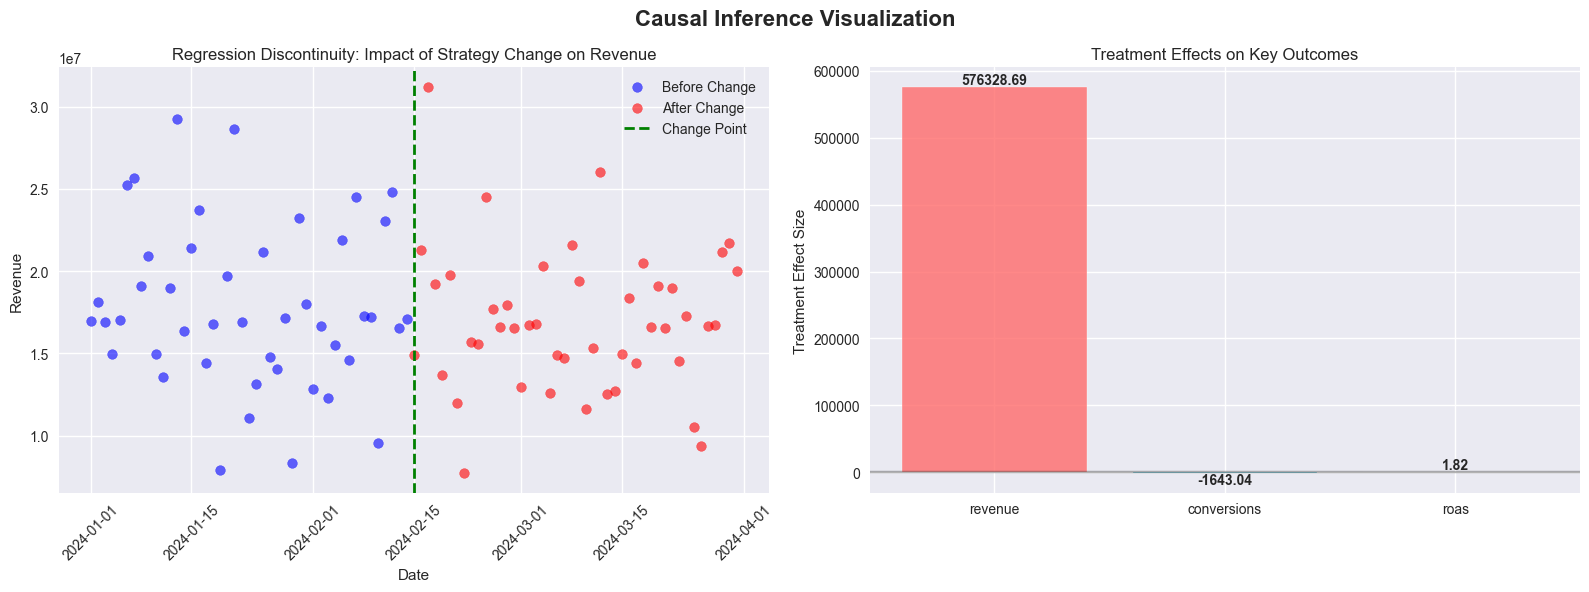

In [19]:
def causal_inference_analysis(df):
    """
    Causal Inference Analysis: Evaluate the true effect of strategy changes
    """
    # Step 1: There is a strategy change: budget increased on Feb 15, 2024
    change_date = pd.Timestamp('2024-02-15')
    
    # Prepare daily data
    daily_data = df.groupby('date').agg({
        'ad_spend': 'sum',
        'revenue': 'sum',
        'conversions': 'sum',
        'roas': 'mean'
    }).reset_index()
    
    daily_data['post_change'] = (daily_data['date'] >= change_date).astype(int)
    daily_data['days_since_start'] = (daily_data['date'] - daily_data['date'].min()).dt.days
    
    # Step 2: Load control group dataset (pre-generated)
    control_data = pd.read_csv("control_data.csv")
    
    # Ensure date is in datetime format
    if 'date' in control_data.columns:
        control_data['date'] = pd.to_datetime(control_data['date'])
    
    treatment_data = daily_data.copy()
    treatment_data['group'] = 'treatment'
    
    # Combine treatment and control data
    did_data = pd.concat([treatment_data, control_data], ignore_index=True)
    did_data['treatment'] = (did_data['group'] == 'treatment').astype(int)
    did_data['post'] = did_data['post_change']
    did_data['treatment_post'] = did_data['treatment'] * did_data['post']
    
    # Step 3: Regression Discontinuity Analysis
    def regression_discontinuity_analysis(data, outcome_var):
        """
        Regression Discontinuity Analysis
        """
        data = data.copy()
        data['days_since_change'] = (data['date'] - change_date).dt.days
        
        X = data[['days_since_change', 'post_change']].copy()
        X['interaction'] = X['days_since_change'] * X['post_change']
        y = data[outcome_var]

        # Fill NaNs
        X = X.fillna(0)
        y = y.fillna(0)
        
        model = LinearRegression()
        model.fit(X, y)
        
        predictions = model.predict(X)
        treatment_effect = model.coef_[1]  # coefficient of post_change
        
        return {
            'treatment_effect': treatment_effect,
            'model': model,
            'predictions': predictions,
            'r_squared': model.score(X, y)
        }
    
    rd_results = {}
    for outcome in ['revenue', 'conversions', 'roas']:
        if outcome in daily_data.columns:
            rd_results[outcome] = regression_discontinuity_analysis(daily_data, outcome)
    
    # Step 4: Difference-in-Differences Analysis
    def difference_in_differences(data, outcome_var):
        """
        Difference-in-Differences Analysis
        """
        X = data[['treatment', 'post', 'treatment_post']]
        y = data[outcome_var]
        
        # Fill NaNs
        X = X.fillna(0)
        y = y.fillna(0)

        model = LinearRegression()
        model.fit(X, y)
        
        did_estimate = model.coef_[2]  # coefficient of treatment_post
        return {
            'did_estimate': did_estimate,
            'model': model,
            'r_squared': model.score(X, y)
        }
    
    did_results = {}
    for outcome in ['revenue', 'conversions']:
        if outcome in did_data.columns:
            did_results[outcome] = difference_in_differences(did_data, outcome)
    
    return rd_results, did_results, daily_data

# Run causal inference analysis
rd_results, did_results, daily_causal = causal_inference_analysis(df_enhanced)

print("=== Causal Inference Analysis Results ===")

print("\n1. Regression Discontinuity Results (Direct Effect of Strategy Change):")
for outcome, result in rd_results.items():
    print(f"\n{outcome}:")
    print(f"  Treatment Effect: {result['treatment_effect']:.4f}")
    print(f"  Model R²: {result['r_squared']:.4f}")
    if result['treatment_effect'] > 0:
        print(f"  Conclusion: Strategy change has a positive effect on {outcome}")
    else:
        print(f"  Conclusion: Strategy change has a negative effect on {outcome}")

print("\n2. Difference-in-Differences Results (Net Effect Excluding External Factors):")
for outcome, result in did_results.items():
    print(f"\n{outcome}:")
    print(f"  DID Estimate: {result['did_estimate']:.4f}")
    print(f"  Model R²: {result['r_squared']:.4f}")
    if result['did_estimate'] > 0:
        print(f"  Conclusion: Net effect of strategy change is positive")
    else:
        print(f"  Conclusion: Net effect of strategy change is negative")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Causal Inference Visualization', fontsize=16, fontweight='bold')

# Scatter plot before and after change (Revenue)
change_date = pd.Timestamp('2024-02-15')
pre_change = daily_causal[daily_causal['date'] < change_date]
post_change = daily_causal[daily_causal['date'] >= change_date]

axes[0].scatter(pre_change['date'], pre_change['revenue'], 
               color='blue', alpha=0.6, label='Before Change')
axes[0].scatter(post_change['date'], post_change['revenue'], 
               color='red', alpha=0.6, label='After Change')
axes[0].axvline(x=change_date, color='green', linestyle='--', linewidth=2, label='Change Point')
axes[0].set_title('Regression Discontinuity: Impact of Strategy Change on Revenue')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Revenue')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Treatment effect bar chart
outcomes = list(rd_results.keys())
treatment_effects = [rd_results[outcome]['treatment_effect'] for outcome in outcomes]
colors = ['#FF6B6B' if effect > 0 else '#45B7D1' for effect in treatment_effects]

bars = axes[1].bar(outcomes, treatment_effects, color=colors, alpha=0.8)
axes[1].set_title('Treatment Effects on Key Outcomes')
axes[1].set_ylabel('Treatment Effect Size')
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)

for bar, effect in zip(bars, treatment_effects):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + (0.1 if height > 0 else -0.1),
                f'{effect:.2f}', ha='center', va='bottom' if height > 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()


## Insights from Causal Inference Analysis

- **Budget Increase Did Not Deliver the Expected Gains**
  - Although RD suggested a short-term increase in revenue and ROAS, these effects were weak (very low R² values).
  - When compared against a control group using DID, the net effect turned negative: revenue and conversions both declined, suggesting that the budget increase reduced overall efficiency rather than driving sustainable growth.

- **Conversions Declined Despite Higher Spending**
  - Both methods indicate that the number of conversions dropped after the strategy change.
  - This implies that additional budget may have been allocated inefficiently, reaching less relevant audiences or driving impressions without meaningful conversions.

- **Strategic Recommendations**
  - **Reassess Budget Allocation**. Consider reallocating spend toward platforms, audiences, or ad formats with historically stronger conversion efficiency rather than simply scaling up spend.
  - **Focus on Conversion Quality**, Not Just Volume.


# 7. Summary

# 📊 Business Insights & Optimization Recommendations

## Core Findings Summary

Based on deep data analysis, we identified the following key business insights:

🎯 **Key Insights Overview**

- **Platform Performance (ROAS):**  
  Xigua > Toutiao ≈ Douyin  
  - Xigua shows the highest ROAS, making it the most efficient platform.  
  - Toutiao and Douyin have similar efficiency, but Douyin carries the largest share of total spend.  

- **Best Performing User Segments:**  
  - **Gen X (36–45 years):** Highest ROAS and AOV → most ROI-driven audience.  
  - **Millennials (26–35 years):** Balanced performance with strong ROAS → valuable target group.  
  - **Gen Z (18–25 years):** High CTR but lower AOV → better suited for engagement and awareness rather than ROI-driven campaigns.  

- **Time Pattern:**  
  - Weekend ROAS is significantly higher than weekdays (41.4 vs 35.3, ~17% increase).  

- **Budget Allocation:**  
  - Douyin absorbs the majority of spend but delivers lower efficiency.  
  - Xigua is under-invested despite the highest return, indicating clear room for budget reallocation.  

- **Ad Type:**  
  - Video Ads and In-feed Ads outperform other types in both CTR and conversions, highlighting the importance of creative execution.  


# 🔧 Data-Driven Short-Term Optimization Strategies

> **Note:** The percentages below are **hypothesis-driven starting points**, not model-fitted prescriptions. We should treat them as test targets and **validate via controlled experiments** (A/B or geo split) with clear guardrails before scaling.

- **Budget Reallocation (Pilot & Validate)**
  - **Shift toward Xigua (+20–30% pilot):** Highest observed ROAS → test incremental budget in 2–3 ramps; **stop-loss** if ROAS drops >10% vs baseline.
  - **Trim Toutiao (−10–15% pilot):** Reallocate released budget to higher-efficiency inventory (primarily Xigua); monitor reach/coverage impact.
  - **Maintain Douyin (optimize mix, not scale):** Keep as top-of-funnel traffic source; improve efficiency via tighter targeting/creatives.
  - **Concentrate on ages 26–45 (Gen X & Millennials):** Allocate +15–25% share toward these segments given superior ROAS/AOV; keep Gen Z for engagement.

- **Time Optimization (Based on Observed Weekend Lift)**
  - **Weekends:** Increase budget **+20–30% (pilot)** to capitalize on ~17% higher ROAS; run a 4-week test with weekday holdout.
  - **Weekdays:** Avoid overemphasizing conversions. Instead, focus on brand awareness and remarketing, while applying stricter CPA/ROAS bidding thresholds to maintain efficiency.

- **Creative & Ad- Type Optimization**
  - **Raise Video & In-feed share to ~60%+:** Especially on Douyin/Xigua where these formats outperform; rotate creatives every 7–10 days to avoid fatigue.
  - **Structured A/B testing:** Test *hook × format × audience* matrix; pre-define success metrics (CTR, CVR, ROAS) and minimum detectable effect; keep one control creative.
  - **Landing-page improvements:** Shorten steps, target <2s mobile load, add trust cues (reviews, guarantees); track CVR uplift and bounce rate.

- **Measurement & Guardrails**
  - **Primary KPIs:** ROAS, CTR & CVR, Revenue; **Secondary:** CPA, AOV.
  - **Experiment design:** 80/20 split or geo split; fixed evaluation window (2–4 weeks); 95% confidence / power-based sample sizing.
  - **Attribution sanity checks:** Compare last-click vs linear/time-decay; annotate all test changes for traceability.

> **Action standard:** Start small (pilot), measure incremental lift, then scale only when **uplift is statistically reliable** and unit economics (ROAS/CPA) remain within targets.
